# Spotify Artist Recommendation Playlist Builder

## Library Imports

In [214]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from pandas.io.json import json_normalize
import sys, re, json, os, datetime
import spotipy
import warnings

#from tools import *
from spotipy.oauth2 import SpotifyClientCredentials
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import sigmoid_kernel
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from collections import Counter


%matplotlib inline

import seaborn as sns
sns.set(style='whitegrid')
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

df = json.load(open('mpd.slice.0-999.json'))
df1 = json.load(open('mpd.slice.238000-238999.json'))
df2 = json.load(open('mpd.slice.188000-188999.json'))
df3 = json.load(open('mpd.slice.351000-351999.json')) 
df4 = json.load(open('mpd.slice.597000-597999.json'))
df5 = json.load(open('mpd.slice.656000-656999.json'))
df6 = json.load(open('mpd.slice.777000-777999.json'))
df7 = json.load(open('mpd.slice.828000-828999.json'))
df8 = json.load(open('mpd.slice.946000-946999.json'))
df9 = json.load(open('mpd.slice.417000-417999.json'))

# EDA & Data Scrubbing

## Open a random 10 files from the 1000 files because of spotify api call limits

In [86]:
with open("mpd.slice.0-999.json","r") as f: 
    df = json.load(f)
df = pd.DataFrame(df["playlists"])
df

,name,collaborative,pid,modified_at,num_tracks,num_albums,num_followers,tracks,num_edits,duration_ms,num_artists,description
0,Throwbacks,false,0,1493424000,52,47,1,"[{'pos': 0, 'artist_name': 'Missy Elliott', 't...",6,11532414,37,NaN
1,Awesome Playlist,false,1,1506556800,39,23,1,"[{'pos': 0, 'artist_name': 'Survivor', 'track_...",5,11656470,21,NaN
2,korean,false,2,1505692800,64,51,1,"[{'pos': 0, 'artist_name': 'Hoody', 'track_uri...",18,14039958,31,NaN
3,mat,false,3,1501027200,126,107,1,"[{'pos': 0, 'artist_name': 'Camille Saint-Saën...",4,28926058,86,NaN
4,90s,false,4,1401667200,17,16,2,"[{'pos': 0, 'artist_name': 'The Smashing Pumpk...",7,4335282,16,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
995,old,false,995,1507852800,41,40,1,"[{'pos': 0, 'artist_name': 'Katrina', 'track_u...",8,9917901,36,NaN
996,Daze,false,996,1479254400,17,17,1,"[{'pos': 0, 'artist_name': 'PARTYNEXTDOOR', 't...",13,3699248,15,NaN
997,rap,false,997,1410307200,119,98,1,"[{'pos': 0, 'artist_name': 'LoveRance', 'track...",63,27538723,82,NaN
998,Country,false,998,1507939200,108,75,1,"[{'pos': 0, 'artist_name': 'Hunter Hayes', 'tr...",37,24950143,40,NaN


In [91]:
# Taking the tracks for each playlist & creating a separate dataframe for it
track_df = []
ply_counter = 0
for track in df['tracks']:
    for one_track in track:
        x = list(one_track.values())
        
        # Making sure each track in the dataframe has a column to indicate which playlist they came from
        x.append(df['name'][ply_counter])
        track_df.append(x)
    ply_counter += 1

track_df = pd.DataFrame(track_df, columns = ['Playlist_pos', 'artist_name','track_uri','artist_uri','track_name','album_uri','duration_ms','album_name','playlist'])  

# Check df
track_df.head(10)

,Playlist_pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms,album_name,playlist
0,0,Missy Elliott,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,spotify:artist:2wIVse2owClT7go1WT98tk,Lose Control (feat. Ciara & Fat Man Scoop),spotify:album:6vV5UrXcfyQD1wu4Qo2I9K,226863,The Cookbook,Throwbacks
1,1,Britney Spears,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,spotify:artist:26dSoYclwsYLMAKD3tpOr4,Toxic,spotify:album:0z7pVBGOD7HCIB7S8eLkLI,198800,In The Zone,Throwbacks
2,2,Beyoncé,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,spotify:artist:6vWDO969PvNqNYHIOW5v0m,Crazy In Love,spotify:album:25hVFAxTlDvXbx2X2QkUkE,235933,Dangerously In Love (Alben für die Ewigkeit),Throwbacks
3,3,Justin Timberlake,spotify:track:1AWQoqb9bSvzTjaLralEkT,spotify:artist:31TPClRtHm23RisEBtV3X7,Rock Your Body,spotify:album:6QPkyl04rXwTGlGlcYaRoW,267266,Justified,Throwbacks
4,4,Shaggy,spotify:track:1lzr43nnXAijIGYnCT8M8H,spotify:artist:5EvFsr3kj42KNv97ZEnqij,It Wasn't Me,spotify:album:6NmFmPX56pcLBOFMhIiKvF,227600,Hot Shot,Throwbacks
5,5,Usher,spotify:track:0XUfyU2QviPAs6bxSpXYG4,spotify:artist:23zg3TcAtWQy7J6upgbUnj,Yeah!,spotify:album:0vO0b1AvY49CPQyVisJLj0,250373,Confessions,Throwbacks
6,6,Usher,spotify:track:68vgtRHr7iZHpzGpon6Jlo,spotify:artist:23zg3TcAtWQy7J6upgbUnj,My Boo,spotify:album:1RM6MGv6bcl6NrAG8PGoZk,223440,Confessions,Throwbacks
7,7,The Pussycat Dolls,spotify:track:3BxWKCI06eQ5Od8TY2JBeA,spotify:artist:6wPhSqRtPu1UhRCDX5yaDJ,Buttons,spotify:album:5x8e8UcCeOgrOzSnDGuPye,225560,PCD,Throwbacks
8,8,Destiny's Child,spotify:track:7H6ev70Weq6DdpZyyTmUXk,spotify:artist:1Y8cdNmUJH7yBTd9yOvr5i,Say My Name,spotify:album:283NWqNsCA9GwVHrJk59CG,271333,The Writing's On The Wall,Throwbacks
9,9,OutKast,spotify:track:2PpruBYCo4H7WOBJ7Q2EwM,spotify:artist:1G9G7WwrXka3Z1r7aIDjI7,Hey Ya! - Radio Mix / Club Mix,spotify:album:1UsmQ3bpJTyK6ygoOOjG1r,235213,Speakerboxxx/The Love Below,Throwbacks


In [251]:
#maybe come up with a function to open 10 random json files

In [16]:
to_drop = ['description', 'num_edits', 'collaborative', 'duration_ms']
df.drop(to_drop, inplace=True, axis=1)

In [89]:
with open("mpd.slice.238000-238999.json","r") as f: 
    df1 = json.load(f)
df1 = pd.DataFrame(df1["playlists"])

In [92]:
# Taking the tracks for each playlist & creating a separate dataframe for it
track_df1 = []
ply_counter = 0
for track in df1['tracks']:
    for one_track in track:
        x = list(one_track.values())
        
        # Making sure each track in the dataframe has a column to indicate which playlist they came from
        x.append(df1['name'][ply_counter])
        track_df1.append(x)
    ply_counter += 1

track_df1 = pd.DataFrame(track_df1, columns = ['Playlist_pos', 'artist_name','track_uri','artist_uri','track_name','album_uri','duration_ms','album_name','playlist'])  

# Check df
track_df1.head(10)

,Playlist_pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms,album_name,playlist
0,0,Gramatik,spotify:track:6aBFjYfhZrgJtxiKaip1BH,spotify:artist:179BpmLkQCRIoU68Co80f5,Skylight,spotify:album:2jufxlYnmvY235bVECkCCq,226333,"Beatz & Pieces, Vol. 1",Beats
1,1,Shlohmo,spotify:track:629Cjw0fUyZUMkBjnjttDR,spotify:artist:6y80I9YZi4DOpbaSUlL725,Places,spotify:album:7BjSjxv8CfoUXRTyW329x2,302210,Bad Vibes,Beats
2,2,Cuthead,spotify:track:1Q5tfzvk1Yx6ZRYKFGsaz9,spotify:artist:1z39BS5hTB0I2kL3w8ux5n,The Poncho,spotify:album:76qwU0D2YDNbIpeRPsUjFx,215500,Total Sellout,Beats
3,3,Samiyam,spotify:track:34wIz7WMyKRfJOenJ3sXYc,spotify:artist:56j1OkSq0AMCgZGKVNc8GP,27,spotify:album:7C2a9Ys91AnGqrTJHXj2ln,58026,Rap Beats Vol. 1,Beats
4,4,PRhyme,spotify:track:5paeaGXCDvRkMkF1rYuSm6,spotify:artist:4ypEjUTTCcPB0dgjQBQyf5,Courtesy - Instrumental,spotify:album:4XiW2dDo7luQxiBCW3Wc3c,212298,PRhyme Instrumentals,Beats
5,5,Baths,spotify:track:4qnvETk1dIsnddsWAEsp2B,spotify:artist:5zS8r5hRRk1jzD41yYS1NO,Animals,spotify:album:2Dt2BZKqxIM5b8hdfmPlP7,198400,Cerulean,Beats
6,6,Photay,spotify:track:3r2CpMRlTWexGhZhQeJtAo,spotify:artist:1MSxOmIt7uYgvPydd1tU8F,No Sass,spotify:album:18rcvgzvr5DMsPNOBwL5Cz,229091,Photay,Beats
7,7,Bahwee,spotify:track:3r5V1X6jScy9VcvEq0bs49,spotify:artist:5SiL5Tx9kfR5waAA9PuHDo,Twentyinmypocket,spotify:album:1nnl1Iq2eSkqvMGsIfV5Wr,163631,Flavors,Beats
8,8,J Dilla,spotify:track:6CmsmQkg655kIZmg22IlVD,spotify:artist:0IVcLMMbm05VIjnzPkGCyp,So Far To Go,spotify:album:4qKDGFz5pQH9NJtRx7qPdb,336813,The Shining,Beats
9,9,Wu-Tang Clan,spotify:track:1zoQsi53rUb67HEo5Kl5DB,spotify:artist:34EP7KEpOjXcM2TCat1ISk,Think Differently - Instrumental,spotify:album:7GvdgeSyGWQ8x7RrchZkU3,278893,Wu-Tang Meets The Indie Culture Instrumentals,Beats


In [13]:
to_drop = ['description', 'num_edits', 'collaborative', 'duration_ms']
df1.drop(to_drop, inplace=True, axis=1)

In [95]:
with open("mpd.slice.188000-188999.json","r") as f: 
    df2 = json.load(f)
df2 = pd.DataFrame(df2["playlists"])


In [96]:
# Taking the tracks for each playlist & creating a separate dataframe for it
track_df2 = []
ply_counter = 0
for track in df2['tracks']:
    for one_track in track:
        x = list(one_track.values())
        
        # Making sure each track in the dataframe has a column to indicate which playlist they came from
        x.append(df2['name'][ply_counter])
        track_df2.append(x)
    ply_counter += 1

track_df2 = pd.DataFrame(track_df2, columns = ['Playlist_pos', 'artist_name','track_uri','artist_uri','track_name','album_uri','duration_ms','album_name','playlist'])  

# Check df
track_df2.head(10)

,Playlist_pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms,album_name,playlist
0,0,Waylon Jennings,spotify:track:5XC3KWPe0XTTSqwxw2rqDK,spotify:artist:7wCjDgV6nqBsHguQXPAaIM,Waymore's Blues,spotify:album:3DDUesugWE5mJjTF5HFsRg,160840,Nashville Rebel,Waylon Jennings
1,1,Waylon Jennings,spotify:track:3GNxGU1AiUzWgYP7jcHj8Q,spotify:artist:7wCjDgV6nqBsHguQXPAaIM,Goin' Down Rockin',spotify:album:2sRs6dIRPjwMrIVioItuxp,238013,Goin' Down Rockin': The Last Recordings,Waylon Jennings
2,2,Waylon Jennings,spotify:track:7DLawBIVohNTngHhRnB37o,spotify:artist:7wCjDgV6nqBsHguQXPAaIM,Outlaw Shit,spotify:album:5tRSywIFhukxe4dsQgi88y,328066,Waylon Forever,Waylon Jennings
3,3,Waylon Jennings,spotify:track:5ft2hncAccU0sa0rbkwm6c,spotify:artist:7wCjDgV6nqBsHguQXPAaIM,Lonesome On'ry and Mean,spotify:album:5tRSywIFhukxe4dsQgi88y,260000,Waylon Forever,Waylon Jennings
4,4,Waylon Jennings,spotify:track:5rlMPBNBnRfROrnQAQRKvA,spotify:artist:7wCjDgV6nqBsHguQXPAaIM,If I Can Find a Clean Shirt,spotify:album:51tjd3OGtsRM68Wt3Rp62C,208693,If I Can Find a Clean Shirt,Waylon Jennings
5,5,Waylon Jennings,spotify:track:3OagKnvsDqltscWZO5TBJj,spotify:artist:7wCjDgV6nqBsHguQXPAaIM,Rough And Rowdy Days,spotify:album:1KiSAPJv57FBLmFnSLpfea,151000,20th Century Masters: The Millennium Collectio...,Waylon Jennings
6,6,Waylon Jennings,spotify:track:6EibL51h5Zplr4Dyj41nDl,spotify:artist:7wCjDgV6nqBsHguQXPAaIM,The Taker,spotify:album:3DDUesugWE5mJjTF5HFsRg,142533,Nashville Rebel,Waylon Jennings
7,7,Waylon Jennings,spotify:track:05G4Jld2muFMnWEqKVLmgq,spotify:artist:7wCjDgV6nqBsHguQXPAaIM,The Chokin' Kind,spotify:album:4LAaQJ9BnVNzNN4jOApk8O,146000,Love Of The Common People,Waylon Jennings
8,8,Waylon Jennings,spotify:track:11C0Qn1bkZ2yPhptlsJWlq,spotify:artist:7wCjDgV6nqBsHguQXPAaIM,Pretend I Never Happened,spotify:album:3DDUesugWE5mJjTF5HFsRg,181866,Nashville Rebel,Waylon Jennings
9,9,Waylon Jennings,spotify:track:1EsTeMFJW9Rk8dr4Nvt3cI,spotify:artist:7wCjDgV6nqBsHguQXPAaIM,You Can Have Her,spotify:album:3DDUesugWE5mJjTF5HFsRg,160506,Nashville Rebel,Waylon Jennings


In [19]:
to_drop = ['description', 'num_edits', 'collaborative', 'duration_ms']
df2.drop(to_drop, inplace=True, axis=1)

In [98]:
with open("mpd.slice.351000-351999.json","r") as f: 
    df3 = json.load(f)
df3 = pd.DataFrame(df3["playlists"])

In [99]:
# Taking the tracks for each playlist & creating a separate dataframe for it
track_df3 = []
ply_counter = 0
for track in df3['tracks']:
    for one_track in track:
        x = list(one_track.values())
        
        # Making sure each track in the dataframe has a column to indicate which playlist they came from
        x.append(df3['name'][ply_counter])
        track_df3.append(x)
    ply_counter += 1

track_df3 = pd.DataFrame(track_df3, columns = ['Playlist_pos', 'artist_name','track_uri','artist_uri','track_name','album_uri','duration_ms','album_name','playlist'])  

# Check df
track_df3.head(10)

,Playlist_pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms,album_name,playlist
0,0,Halsey,spotify:track:16w8ZGVSjI4TlTLV8VimBY,spotify:artist:26VFTg2z8YR0cCuwLzESi2,Castle,spotify:album:5OZJflQcQCdZLQjtUudCin,277623,BADLANDS,Juan
1,1,Ed Sheeran,spotify:track:1Slwb6dOYkBlWal1PGtnNg,spotify:artist:6eUKZXaKkcviH0Ku9w2n3V,Thinking Out Loud,spotify:album:6NoBzYmh5gUusGPCfg0pct,281560,x,Juan
2,2,Jason Derulo,spotify:track:6jizk5lOUnfpaZXYMdfeC6,spotify:artist:07YZf4WDAMNwqr4jfgOZ8y,Trumpets,spotify:album:1OdcBxCNY52OXH0r4odXqP,217306,Tattoos,Juan
3,3,The Lumineers,spotify:track:6ZYS6QQxTLsQ6IFXdVx1r4,spotify:artist:16oZKvXb6WkQlVAjwo2Wbg,Ophelia,spotify:album:03WMNRxqKog3sBZ6G5jGDw,160106,Cleopatra,Juan
4,4,Lukas Graham,spotify:track:7129iqBafaphfc3WPCGC0L,spotify:artist:25u4wHJWxCA9vO0CzxAbK7,7 Years,spotify:album:6NQ2RNksdSKdtnlFOLJo24,237300,Lukas Graham (Blue Album),Juan
5,5,ZAYN,spotify:track:0PDUDa38GO8lMxLCRc4lL1,spotify:artist:5ZsFI1h6hIdQRw2ti0hz81,PILLOWTALK,spotify:album:5amj9zNeZ3B2EdpBgXrOZ0,202746,Mind Of Mine (Deluxe Edition),Juan
6,6,Kurt Hugo Schneider,spotify:track:2aFP72ibtJVJJEwnvv0xlz,spotify:artist:2BHswvFd8tMBizVWGcAMLm,Send My Love (To Your New Lover),spotify:album:2Q8rtQ3VdGJDBwPailR7f3,210731,Everyday Sounds I,Juan
7,7,Alessia Cara,spotify:track:1wYZZtamWTQAoj8B812uKQ,spotify:artist:2wUjUUtkb5lvLKcGKsKqsR,Here,spotify:album:3rDbA12I5duZnlwakqDdZa,199453,Know-It-All,Juan
8,8,Passenger,spotify:track:2JXnsuFhfVgLHPL1mp3xdW,spotify:artist:0gadJ2b9A4SKsB1RFkBb66,Let Her Go - Live At Spotify Amsterdam,spotify:album:6gMzMZ9HpMXosMlu2JtGti,223573,Spotify Session,Juan
9,9,The Civil Wars,spotify:track:06FVwC9lTks2JmCO9IKB4H,spotify:artist:6J7rw7NELJUCThPbAfyLIE,Girl with the Red Balloon,spotify:album:6tQjO7LXVL6byHa0ZF4emD,229520,Barton Hollow,Juan


In [27]:
to_drop = ['description', 'num_edits', 'collaborative', 'duration_ms']
df3.drop(to_drop, inplace=True, axis=1)

In [100]:
with open("mpd.slice.597000-597999.json","r") as f: 
    df4 = json.load(f)
df4 = pd.DataFrame(df4["playlists"])

In [101]:
 # Taking the tracks for each playlist & creating a separate dataframe for it
track_df4 = []
ply_counter = 0
for track in df4['tracks']:
    for one_track in track:
        x = list(one_track.values())
        
        # Making sure each track in the dataframe has a column to indicate which playlist they came from
        x.append(df4['name'][ply_counter])
        track_df4.append(x)
    ply_counter += 1

track_df4 = pd.DataFrame(track_df4, columns = ['Playlist_pos', 'artist_name','track_uri','artist_uri','track_name','album_uri','duration_ms','album_name','playlist'])  

# Check df
track_df4.head(10)

,Playlist_pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms,album_name,playlist
0,0,Missy Elliott,spotify:track:4Z1GSvE92RKsxjzrrBJAIT,spotify:artist:2wIVse2owClT7go1WT98tk,One Minute Man (feat. Jay-Z) - Remix,spotify:album:20t54K6C80QQH7vbcpfJcP,275600,Miss E...So Addictive,90's Hip Hop
1,1,Nas,spotify:track:3qRPc4QpHGNwKFAzCdqwxA,spotify:artist:20qISvAhX20dpIbOOzGK3q,Made You Look,spotify:album:3rV1aPkrWyMs6YTvTpSbIY,203000,God's Son,90's Hip Hop
2,2,Total,spotify:track:174UISK3l7VRbigEHxEev7,spotify:artist:1urjDGTd4iBze91Z1W1gu7,Can't You See (feat. The Notorious B.I.G.),spotify:album:4uLoT81NWVFx09mkfnGCHb,281880,Total,90's Hip Hop
3,3,The Notorious B.I.G.,spotify:track:61fT12l0R16DiB9dd4zkfy,spotify:artist:5me0Irg2ANcsgc93uaYrpb,Just Playing (Dreams),spotify:album:2HTbQ0RHwukKVXAlTmCZP2,163466,Ready To Die The Remaster,90's Hip Hop
4,4,The Notorious B.I.G.,spotify:track:7KwZNVEaqikRSBSpyhXK2j,spotify:artist:5me0Irg2ANcsgc93uaYrpb,Hypnotize - 2014 Remastered Version,spotify:album:7dRdaGSxgcBdJnrOviQRuB,229826,Life After Death (Remastered Edition),90's Hip Hop
5,5,The Notorious B.I.G.,spotify:track:5ByAIlEEnxYdvpnezg7HTX,spotify:artist:5me0Irg2ANcsgc93uaYrpb,Juicy,spotify:album:2HTbQ0RHwukKVXAlTmCZP2,302693,Ready To Die The Remaster,90's Hip Hop
6,6,The Notorious B.I.G.,spotify:track:2g8HN35AnVGIk7B8yMucww,spotify:artist:5me0Irg2ANcsgc93uaYrpb,Big Poppa,spotify:album:2HTbQ0RHwukKVXAlTmCZP2,252746,Ready To Die The Remaster,90's Hip Hop
7,7,The Notorious B.I.G.,spotify:track:7fXhkARAtS66kxexMIAx8O,spotify:artist:5me0Irg2ANcsgc93uaYrpb,One More Chance/Stay With Me - Remix,spotify:album:5XqEf16OrHdmMoNS1b6WDg,268706,Greatest Hits,90's Hip Hop
8,8,Junior M.A.F.I.A.,spotify:track:53oWwSxPuyH2cjYKXH8fgO,spotify:artist:3r0OeTcOw37N9juMYyyw39,Get Money - LP-Explicit Version,spotify:album:02GVhWjMuoQBQUtNhjWsnG,274937,Conspiracy,90's Hip Hop
9,9,The Notorious B.I.G.,spotify:track:2KFg8kjYy0rYjWsXGhEQHN,spotify:artist:5me0Irg2ANcsgc93uaYrpb,Who Shot Ya,spotify:album:2HTbQ0RHwukKVXAlTmCZP2,319373,Ready To Die The Remaster,90's Hip Hop


In [28]:
to_drop = ['description', 'num_edits', 'collaborative', 'duration_ms']
df4.drop(to_drop, inplace=True, axis=1)

In [102]:
with open("mpd.slice.656000-656999.json","r") as f: 
    df5 = json.load(f)
df5 = pd.DataFrame(df5["playlists"])

In [103]:
# Taking the tracks for each playlist & creating a separate dataframe for it
track_df5 = []
ply_counter = 0
for track in df5['tracks']:
    for one_track in track:
        x = list(one_track.values())
        
        # Making sure each track in the dataframe has a column to indicate which playlist they came from
        x.append(df5['name'][ply_counter])
        track_df5.append(x)
    ply_counter += 1

track_df5 = pd.DataFrame(track_df5, columns = ['Playlist_pos', 'artist_name','track_uri','artist_uri','track_name','album_uri','duration_ms','album_name','playlist'])  

# Check df
track_df5.head(10)

,Playlist_pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms,album_name,playlist
0,0,21 Savage,spotify:track:4gmmRb6bZJffOOiww1JGTO,spotify:artist:1URnnhqYAYcrqrcwql10ft,No Heart,spotify:album:4I3EcXD4e3KcEoDJfFEZ5b,235040,Savage Mode,My Tunes
1,1,21 Savage,spotify:track:6fwdbPMwP1zVStm8FybmkO,spotify:artist:1URnnhqYAYcrqrcwql10ft,X (feat. Future),spotify:album:4I3EcXD4e3KcEoDJfFEZ5b,258880,Savage Mode,My Tunes
2,2,21 Savage,spotify:track:3xAXYCtd98G5G0SSJAHtqd,spotify:artist:1URnnhqYAYcrqrcwql10ft,Dip Dip,spotify:album:1HSyuTHvLXMWyPJQGnQTLw,151614,Slaughter King,My Tunes
3,3,21 Savage,spotify:track:6g0TAJ1grweRwBMLQyiZFb,spotify:artist:1URnnhqYAYcrqrcwql10ft,Famous,spotify:album:4QUNWTw2FsIz722xjUjFJw,234280,Issa Album,My Tunes
4,4,21 Savage,spotify:track:2fQrGHiQOvpL9UgPvtYy6G,spotify:artist:1URnnhqYAYcrqrcwql10ft,Bank Account,spotify:album:4QUNWTw2FsIz722xjUjFJw,220306,Issa Album,My Tunes
5,5,6LACK,spotify:track:4AtZRwSR8BOTTQg5ihSggt,spotify:artist:4IVAbR2w4JJNJDDRFP3E83,PRBLMS,spotify:album:7iwGw8ob3YLqZrbKzGFnHi,246773,FREE 6LACK,My Tunes
6,6,6LACK,spotify:track:1MQ8ydvrTnn2QJgXFATJvD,spotify:artist:4IVAbR2w4JJNJDDRFP3E83,Ex Calling,spotify:album:7iwGw8ob3YLqZrbKzGFnHi,211960,FREE 6LACK,My Tunes
7,7,2 Chainz,spotify:track:7s8NiGsmHTT7K9CLIKvkSW,spotify:artist:17lzZA2AlOHwCwFALHttmp,A Milli Billi Trilli,spotify:album:0HiyOnSs0O9vptexgk9Bh4,195426,TrapAvelli Tre,My Tunes
8,8,2 Chainz,spotify:track:1gpSrGUfU3F9TOzPlEyLxH,spotify:artist:17lzZA2AlOHwCwFALHttmp,Gotta Lotta,spotify:album:56TQNcSoy3eQpyWtNwQnrD,214720,COLLEGROVE,My Tunes
9,9,2 Chainz,spotify:track:39pS70eeDvyCAF3t8NAlVV,spotify:artist:17lzZA2AlOHwCwFALHttmp,Good Drank,spotify:album:5vvvo79z68vWj9yimoygfS,222706,Pretty Girls Like Trap Music,My Tunes


In [29]:
to_drop = ['description', 'num_edits', 'collaborative', 'duration_ms']
df5.drop(to_drop, inplace=True, axis=1)

In [104]:
with open("mpd.slice.777000-777999.json","r") as f: 
    df6 = json.load(f)
df6 = pd.DataFrame(df6["playlists"])

In [105]:
# Taking the tracks for each playlist & creating a separate dataframe for it
track_df6 = []
ply_counter = 0
for track in df6['tracks']:
    for one_track in track:
        x = list(one_track.values())
        
        # Making sure each track in the dataframe has a column to indicate which playlist they came from
        x.append(df6['name'][ply_counter])
        track_df6.append(x)
    ply_counter += 1

track_df6 = pd.DataFrame(track_df6, columns = ['Playlist_pos', 'artist_name','track_uri','artist_uri','track_name','album_uri','duration_ms','album_name','playlist'])  

# Check df
track_df6.head(10)

,Playlist_pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms,album_name,playlist
0,0,Luke Bryan,spotify:track:1PoGWZbJPGmViVi7CYbDUK,spotify:artist:0BvkDsjIUla7X0k6CSWh1I,Drink A Beer,spotify:album:5M8gr5RV2eR6UkztC69ogB,202626,Crash My Party,County
1,1,Luke Bryan,spotify:track:03fT3OHB9KyMtGMt2zwqCT,spotify:artist:0BvkDsjIUla7X0k6CSWh1I,Play It Again,spotify:album:5M8gr5RV2eR6UkztC69ogB,226866,Crash My Party,County
2,2,Luke Bryan,spotify:track:5HGibWoxnkYSkl6mHmAlOE,spotify:artist:0BvkDsjIUla7X0k6CSWh1I,That's My Kind Of Night,spotify:album:5M8gr5RV2eR6UkztC69ogB,190186,Crash My Party,County
3,3,Luke Bryan,spotify:track:3b7CDTKB0SRTmQ6ytYi5vZ,spotify:artist:0BvkDsjIUla7X0k6CSWh1I,Drunk On You,spotify:album:4ybWq0AegFFAvHULAe7q0K,213546,Tailgates & Tanlines,County
4,4,Luke Bryan,spotify:track:7nbYuquNV8MvCY0Ut7YpLd,spotify:artist:0BvkDsjIUla7X0k6CSWh1I,Shut It Down,spotify:album:5M8gr5RV2eR6UkztC69ogB,195973,Crash My Party,County
5,5,Lee Brice,spotify:track:5Kb5utdaR6qXYZ9WpgoKWm,spotify:artist:5Zq7R5qmi58ByYyBQTlNuk,Drinking class,spotify:album:1Ug5qpIXouUHY5hpFj6575,207346,I Don't Dance,County
6,6,Lee Brice,spotify:track:2YCQff1CDLnQ4dzjAfE1VG,spotify:artist:5Zq7R5qmi58ByYyBQTlNuk,I Drive Your Truck,spotify:album:00V6Eg95EFSbvLiQpMUmCE,243653,I Drive Your Truck,County
7,7,Lee Brice,spotify:track:5aj0xPGiEUN3aI2oOYu14S,spotify:artist:5Zq7R5qmi58ByYyBQTlNuk,I Don't Dance,spotify:album:2XIhZ9IjqoIN5V6dfKHzCn,221173,I Don't Dance,County
8,8,Blake Shelton,spotify:track:3JffB4CABj9lA0NC63kbCp,spotify:artist:1UTPBmNbXNTittyMJrNkvw,She's Got a Way With Words,spotify:album:4JmphteFDt5gNZbgraR9Dc,190986,If I'm Honest,County
9,9,Blake Shelton,spotify:track:0y44Oz1T9uWDKg4SFDWRWH,spotify:artist:1UTPBmNbXNTittyMJrNkvw,Honey Bee,spotify:album:7qyfoJ9YCVfBnePdxBFbhx,210720,Loaded: The Best Of Blake Shelton,County


In [30]:
to_drop = ['description', 'num_edits', 'collaborative', 'duration_ms']
df6.drop(to_drop, inplace=True, axis=1)

In [106]:
with open("mpd.slice.828000-828999.json","r") as f: 
    df7 = json.load(f)
df7 = pd.DataFrame(df7["playlists"])

In [107]:
# Taking the tracks for each playlist & creating a separate dataframe for it
track_df7 = []
ply_counter = 0
for track in df7['tracks']:
    for one_track in track:
        x = list(one_track.values())
        
        # Making sure each track in the dataframe has a column to indicate which playlist they came from
        x.append(df7['name'][ply_counter])
        track_df7.append(x)
    ply_counter += 1

track_df7 = pd.DataFrame(track_df7, columns = ['Playlist_pos', 'artist_name','track_uri','artist_uri','track_name','album_uri','duration_ms','album_name','playlist'])  

# Check df
track_df7.head(10)

,Playlist_pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms,album_name,playlist
0,0,Faze Wave,spotify:track:0wQbk9sAkZflH2ht0FC5G7,spotify:artist:7rsBReXv6wZK0s0nGN3yzF,Makeout,spotify:album:0ONVr5a3zRKThzRJK9aaBq,190749,Makeout,Makeout
1,1,Hitting The Rhodes,spotify:track:3uZlxLpNhom1ts3GOGS6po,spotify:artist:60haZt1bS1moHbG1Vjd3oq,Hey Ya Cover By Hitting The Rhodes,spotify:album:2Cjcaf9QxTkc6ZseqEk2HT,146227,Hey Ya Cover By Hitting The Rhodes,Makeout
2,2,Concorde,spotify:track:4fmU11hc9cNOvnD1rvddUl,spotify:artist:5gSzpQeKekCGJTR9hcWwKF,Just Kiss Her,spotify:album:23qAGuV2cnNN2wR8zgayIC,302532,Summer House,Makeout
3,3,The Happy Fits,spotify:track:4YDbjd5K0tNntyeWg0HSY8,spotify:artist:73rPcaYEhBd0UuVZBqqyQJ,Drink,spotify:album:2L4dQBiAsOxEFwjGqduCEI,230990,Awfully Apeelin',Makeout
4,4,SWMRS,spotify:track:0Ceozg27V0Ws9jgQixD8fr,spotify:artist:7dLkuQHF2ijbK6jiLFyIWM,Lose It,spotify:album:3KbuvIJRqejRJ4gtO9xwC3,240533,Drive North,Makeout
5,5,Beach Weather,spotify:track:04wODYKrbLNe7LTOaOPX3i,spotify:artist:7I3bkknknQkIiatWiupQgD,"Sex, Drugs, Etc.",spotify:album:6ygLpSyAvRSKGZw1LZkxOX,196784,Chit Chat,Makeout
6,6,Folded Like Fabric,spotify:track:3WZISkRbc2ppp69sQch8cq,spotify:artist:2Gt8bzahH9RSMrH6heY2vF,Falling and You Caught Me,spotify:album:21h2o7XD2TnrwNCtwrn1Uh,205466,Falling and You Caught Me,Makeout
7,7,Elliot Root,spotify:track:3hbYJfgdAcfCsKFEZS7E5s,spotify:artist:2czQ8vG4i3wBWxfsAt4yqw,Body Down,spotify:album:0bTG6s0dKmgvvbrfyGnQtQ,330710,2,Makeout
8,8,Gavin Castleton,spotify:track:0RXzJgQPsDUC51mzpgQ8w5,spotify:artist:7dHVJaHEBEbN1R1ZhYD20u,Swim Good,spotify:album:0QYtxsFwYDTeKHVGjmBUIq,258607,Covers,Makeout
9,9,Kiiara,spotify:track:7urOj7zwJa2rG5eWc7Nz4W,spotify:artist:4u5smJBskI6Adzv08PuiUP,Feels,spotify:album:5l9xEYHyPmQYTiXHbqlydt,182500,Feels,Makeout


In [31]:
to_drop = ['description', 'num_edits', 'collaborative', 'duration_ms']
df7.drop(to_drop, inplace=True, axis=1)

In [108]:
with open("mpd.slice.946000-946999.json","r") as f: 
    df8 = json.load(f)
df8 = pd.DataFrame(df8["playlists"])

In [109]:
# Taking the tracks for each playlist & creating a separate dataframe for it
track_df8 = []
ply_counter = 0
for track in df8['tracks']:
    for one_track in track:
        x = list(one_track.values())
        
        # Making sure each track in the dataframe has a column to indicate which playlist they came from
        x.append(df8['name'][ply_counter])
        track_df8.append(x)
    ply_counter += 1

track_df8 = pd.DataFrame(track_df8, columns = ['Playlist_pos', 'artist_name','track_uri','artist_uri','track_name','album_uri','duration_ms','album_name','playlist'])  

# Check df
track_df8.head(10)

,Playlist_pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms,album_name,playlist
0,0,Red Hot Chili Peppers,spotify:track:3d9DChrdc6BOeFsbrZ3Is0,spotify:artist:0L8ExT028jH3ddEcZwqJJ5,Under The Bridge,spotify:album:30Perjew8HyGkdSmqguYyg,264306,Blood Sugar Sex Magik,Karaoke
1,1,Sublime,spotify:track:1px4PgELXjVzJgBjwPvTiG,spotify:artist:0EdvGhlC1FkGItLOWQzG4J,Caress Me Down,spotify:album:243wqukvimLglvClDVsfHJ,211733,Sublime,Karaoke
2,2,Sublime,spotify:track:0Jur3mZsQba3vqSpcmsOPm,spotify:artist:0EdvGhlC1FkGItLOWQzG4J,Smoke Two Joints,spotify:album:0vuwlanMPucXrYMGnOjhYL,173426,40oz. To Freedom,Karaoke
3,3,Sublime,spotify:track:3Cx9j78Z0NE6jYwBWvvV3P,spotify:artist:0EdvGhlC1FkGItLOWQzG4J,Waiting For My Ruca,spotify:album:0vuwlanMPucXrYMGnOjhYL,140226,40oz. To Freedom,Karaoke
4,4,Sublime,spotify:track:0Ylaocf86J0PZAhjAP8wzl,spotify:artist:0EdvGhlC1FkGItLOWQzG4J,Doin' Time,spotify:album:4R3tXoorBpHji6Jdms8a4Q,253333,Sublime,Karaoke
5,5,Sublime,spotify:track:0yhvwYw9KeWrq8nRjtTjNH,spotify:artist:0EdvGhlC1FkGItLOWQzG4J,Pawn Shop,spotify:album:243wqukvimLglvClDVsfHJ,366013,Sublime,Karaoke
6,6,Sublime,spotify:track:1GcT1n4CCo0Mqcyu7fjOM5,spotify:artist:0EdvGhlC1FkGItLOWQzG4J,Date Rape,spotify:album:4R3tXoorBpHji6Jdms8a4Q,215893,Sublime,Karaoke
7,7,Don McLean,spotify:track:1fDsrQ23eTAVFElUMaf38X,spotify:artist:1gRNBaI4yn6wCCTvRhGWh8,American Pie,spotify:album:10jsW2NYd9blCrDITMh2zS,516893,American Pie,Karaoke
8,8,Sublime,spotify:track:2Z2vOukzwOgqR4dkymRSWd,spotify:artist:0EdvGhlC1FkGItLOWQzG4J,Santeria,spotify:album:4R3tXoorBpHji6Jdms8a4Q,182500,Sublime,Karaoke
9,9,Sublime,spotify:track:5nkYHBWXu7KCgcdwP6jcB1,spotify:artist:0EdvGhlC1FkGItLOWQzG4J,What I Got,spotify:album:4R3tXoorBpHji6Jdms8a4Q,171066,Sublime,Karaoke


In [32]:
to_drop = ['description', 'num_edits', 'collaborative', 'duration_ms']
df8.drop(to_drop, inplace=True, axis=1)

In [141]:
with open("mpd.slice.417000-417999.json","r") as f: 
    df9 = json.load(f)
df9 = pd.DataFrame(df9["playlists"])

In [143]:
# Taking the tracks for each playlist & creating a separate dataframe for it
track_df9 = []
ply_counter = 0
for track in df9['tracks']:
    for one_track in track:
        x = list(one_track.values())
        
        # Making sure each track in the dataframe has a column to indicate which playlist they came from
        x.append(df9['name'][ply_counter])
        track_df9.append(x)
    ply_counter += 1

track_df9 = pd.DataFrame(track_df9, columns = ['Playlist_pos', 'artist_name','track_uri','artist_uri','track_name','album_uri','duration_ms','album_name','playlist'])  

# Check df
track_df9.head(10)

,Playlist_pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms,album_name,playlist
0,0,Kygo,spotify:track:5masKPHeAOVNgxdLebIcK7,spotify:artist:23fqKkggKUBHNkbKtXEls4,Stole the Show,spotify:album:0uMIzWh1uEpHEBell4rlF8,222801,Cloud Nine,kygo
1,1,Kygo,spotify:track:1I8tHoNBFTuoJAlh4hfVVE,spotify:artist:23fqKkggKUBHNkbKtXEls4,Firestone,spotify:album:0uMIzWh1uEpHEBell4rlF8,273684,Cloud Nine,kygo
2,2,Kygo,spotify:track:2fZW7ByWe46rGih0FtP2XK,spotify:artist:23fqKkggKUBHNkbKtXEls4,Nothing Left,spotify:album:0uMIzWh1uEpHEBell4rlF8,236682,Cloud Nine,kygo
3,3,Kygo,spotify:track:73iyt0DBfDKsMSjJStycGC,spotify:artist:23fqKkggKUBHNkbKtXEls4,Here for You,spotify:album:4yVS2215G17dOUpqhwHJrV,245346,Cloud Nine,kygo
4,4,Dillon Francis,spotify:track:6m3ZWIXhjoV76syT1j2oE9,spotify:artist:5R3Hr2cnCCjt220Jmt2xLf,Coming Over (feat. James Hersey),spotify:album:5yscEifoZw3M3abIVCr8ed,178333,This Mixtape is Fire.,kygo
5,5,Marvin Gaye,spotify:track:7s1upm7yr7ZjrzXMwHawtG,spotify:artist:3koiLjNrgRTNbOwViDipeA,Sexual Healing - Kygo Remix,spotify:album:6j62lF3YXsygj6xTjAyRG5,368316,Sexual Healing,kygo
6,6,Kyla La Grange,spotify:track:4F4hKCEgevJgNq27pYz0Mk,spotify:artist:6KcmUwBzfwLaYxdfIboqcp,Cut Your Teeth - Kygo Remix,spotify:album:4yVS2215G17dOUpqhwHJrV,395880,Cloud Nine,kygo
7,7,Kygo,spotify:track:4SBqydJCEhcroni09XgT2c,spotify:artist:23fqKkggKUBHNkbKtXEls4,ID - Ultra Music Festival Anthem,spotify:album:08lvNATRudyG5K7eEjWk1t,289987,ID,kygo
8,8,Kygo,spotify:track:4gek9UL5WceAq1qiZlhmGM,spotify:artist:23fqKkggKUBHNkbKtXEls4,Firestone - Live Acoustic Version,spotify:album:2LkJP9u5oUPaum7gBHBKJy,226345,Firestone,kygo
9,9,Syn Cole,spotify:track:7l15QDWp4v3TYh5u3pQjxa,spotify:artist:6i1GVNJCyyssRwXmnaeEFH,Miami 82 - Kygo Remix,spotify:album:1cVyMj4skGmb4uYJWbC95c,341946,Miami 82,kygo


In [33]:
to_drop = ['description', 'num_edits', 'collaborative', 'duration_ms']
df9.drop(to_drop, inplace=True, axis=1)

In [113]:
df1.corr()

,pid,modified_at,num_tracks,num_albums,num_followers,num_edits,duration_ms,num_artists
pid,1.000000,-0.007849,-0.058198,-0.047188,0.002324,-0.002630,-0.060087,-0.050985
modified_at,-0.007849,1.000000,0.188534,0.224921,-0.005976,0.219060,0.177635,0.223169
num_tracks,-0.058198,0.188534,1.000000,0.908018,0.036804,0.617878,0.986986,0.838957
num_albums,-0.047188,0.224921,0.908018,1.000000,0.054494,0.699889,0.900097,0.966384
num_followers,0.002324,-0.005976,0.036804,0.054494,1.000000,0.083960,0.039571,0.061298
num_edits,-0.002630,0.219060,0.617878,0.699889,0.083960,1.000000,0.620743,0.708127
duration_ms,-0.060087,0.177635,0.986986,0.900097,0.039571,0.620743,1.000000,0.827751
num_artists,-0.050985,0.223169,0.838957,0.966384,0.061298,0.708127,0.827751,1.000000


## combine 10 datasets together for the api call

In [144]:
merged_df = pd.concat([track_df, track_df1, track_df2, track_df3, track_df4, track_df5, track_df6, track_df7, track_df8, track_df9])

In [145]:
merged_df.head()

,Playlist_pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms,album_name,playlist
0,0,Missy Elliott,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,spotify:artist:2wIVse2owClT7go1WT98tk,Lose Control (feat. Ciara & Fat Man Scoop),spotify:album:6vV5UrXcfyQD1wu4Qo2I9K,226863,The Cookbook,Throwbacks
1,1,Britney Spears,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,spotify:artist:26dSoYclwsYLMAKD3tpOr4,Toxic,spotify:album:0z7pVBGOD7HCIB7S8eLkLI,198800,In The Zone,Throwbacks
2,2,Beyoncé,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,spotify:artist:6vWDO969PvNqNYHIOW5v0m,Crazy In Love,spotify:album:25hVFAxTlDvXbx2X2QkUkE,235933,Dangerously In Love (Alben für die Ewigkeit),Throwbacks
3,3,Justin Timberlake,spotify:track:1AWQoqb9bSvzTjaLralEkT,spotify:artist:31TPClRtHm23RisEBtV3X7,Rock Your Body,spotify:album:6QPkyl04rXwTGlGlcYaRoW,267266,Justified,Throwbacks
4,4,Shaggy,spotify:track:1lzr43nnXAijIGYnCT8M8H,spotify:artist:5EvFsr3kj42KNv97ZEnqij,It Wasn't Me,spotify:album:6NmFmPX56pcLBOFMhIiKvF,227600,Hot Shot,Throwbacks


In [146]:
merged_df.shape

(668663, 9)

In [121]:
merged_df['artist_name'].value_counts()

Drake                               8797
Kanye West                          4281
Kendrick Lamar                      3497
Rihanna                             3442
The Weeknd                          3392
                                    ... 
Ballout                                1
Casey Jones                            1
Chalino Sanchez Y Cornelio Reyna       1
The Wardlaw Brothers                   1
Boxed Wine                             1
Name: artist_name, Length: 36591, dtype: int64

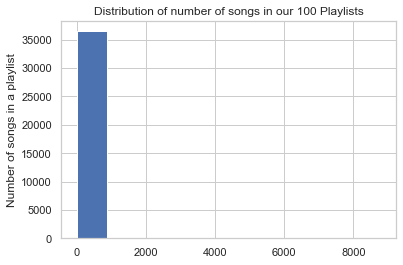

In [123]:
plt.hist(merged_df['artist_name'].value_counts())
plt.title("Distribution of number of songs in our 100 Playlists")
plt.ylabel("Count")
plt.ylabel("Number of songs in a playlist")
plt.show()

In [124]:
merged_df.dtypes

Playlist_pos     int64
artist_name     object
track_uri       object
artist_uri      object
track_name      object
album_uri       object
duration_ms      int64
album_name      object
playlist        object
dtype: object

In [147]:
#drop duplicate songs to clean up dataset, and make api calls closer to limit, 668k rows lowered to 134k
merged_df.drop_duplicates('track_name',inplace = True)

In [148]:
merged_df

,Playlist_pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms,album_name,playlist
0,0,Missy Elliott,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,spotify:artist:2wIVse2owClT7go1WT98tk,Lose Control (feat. Ciara & Fat Man Scoop),spotify:album:6vV5UrXcfyQD1wu4Qo2I9K,226863,The Cookbook,Throwbacks
1,1,Britney Spears,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,spotify:artist:26dSoYclwsYLMAKD3tpOr4,Toxic,spotify:album:0z7pVBGOD7HCIB7S8eLkLI,198800,In The Zone,Throwbacks
2,2,Beyoncé,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,spotify:artist:6vWDO969PvNqNYHIOW5v0m,Crazy In Love,spotify:album:25hVFAxTlDvXbx2X2QkUkE,235933,Dangerously In Love (Alben für die Ewigkeit),Throwbacks
3,3,Justin Timberlake,spotify:track:1AWQoqb9bSvzTjaLralEkT,spotify:artist:31TPClRtHm23RisEBtV3X7,Rock Your Body,spotify:album:6QPkyl04rXwTGlGlcYaRoW,267266,Justified,Throwbacks
4,4,Shaggy,spotify:track:1lzr43nnXAijIGYnCT8M8H,spotify:artist:5EvFsr3kj42KNv97ZEnqij,It Wasn't Me,spotify:album:6NmFmPX56pcLBOFMhIiKvF,227600,Hot Shot,Throwbacks
...,...,...,...,...,...,...,...,...,...
67911,43,Cole Turner,spotify:track:7e5CVfXtcwJLaWBrGQvvo9,spotify:artist:6BESPq5NL3lWXByDFn6cPj,Here Comes the Hot Stepper,spotify:album:0o2o2lpheMEFaTdgJcE8BK,238253,Red Hot Reggae,Skate Music
67917,49,Jackyl,spotify:track:1Q0ngcqxEr5GpDGfh5VAvZ,spotify:artist:3jdirYL01245TvAH39GfM6,The Lumberjack,spotify:album:1SzvaAWHRI4NN3sRfUdOzW,212106,Jackyl,Skate Music
67926,58,Saturday Night Fever,spotify:track:1yZLRUuMs8sOvFCXyhUeWq,spotify:artist:3PhkrqEEE8JMMo6hf7V9bh,A Fifth of Beethoven,spotify:album:2K7Fj9CYp5qzwXf6hAlZCm,184078,"Disco Hits of The '70s, '80s & '90s",Skate Music
67927,59,Anita Ward,spotify:track:5XHnhjqYz8wqsZO09vudiA,spotify:artist:3Dd6jD1AApgtNoU6SJWR7P,Ring My Bell (Re-Recorded) [Remastered],spotify:album:3hU3gN6GgBoT9MdCzWha02,230880,Ring My Bell (Dubstep Remix),Skate Music


In [149]:
#make sure no repeat of songs
merged_df['track_name'].value_counts()

Gin And Juice (feat. Dat Nigga Daz)                           1
No Problems (feat. Rico Love)                                 1
I Gotta Believe                                               1
Donkey!                                                       1
Butch                                                         1
                                                             ..
Pixel                                                         1
Three Romances for Clarinet and Piano, Op. 94: I. Moderato    1
If You Could Hie to Kolob                                     1
Glide                                                         1
Macumba                                                       1
Name: track_name, Length: 134515, dtype: int64

In [138]:
to_drop = ['Playlist_pos']
merged_df.drop(to_drop, inplace=True, axis=1)

In [139]:
merged_df

,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms,album_name,playlist
0,Missy Elliott,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,spotify:artist:2wIVse2owClT7go1WT98tk,Lose Control (feat. Ciara & Fat Man Scoop),spotify:album:6vV5UrXcfyQD1wu4Qo2I9K,226863,The Cookbook,Throwbacks
1,Britney Spears,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,spotify:artist:26dSoYclwsYLMAKD3tpOr4,Toxic,spotify:album:0z7pVBGOD7HCIB7S8eLkLI,198800,In The Zone,Throwbacks
2,Beyoncé,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,spotify:artist:6vWDO969PvNqNYHIOW5v0m,Crazy In Love,spotify:album:25hVFAxTlDvXbx2X2QkUkE,235933,Dangerously In Love (Alben für die Ewigkeit),Throwbacks
3,Justin Timberlake,spotify:track:1AWQoqb9bSvzTjaLralEkT,spotify:artist:31TPClRtHm23RisEBtV3X7,Rock Your Body,spotify:album:6QPkyl04rXwTGlGlcYaRoW,267266,Justified,Throwbacks
4,Shaggy,spotify:track:1lzr43nnXAijIGYnCT8M8H,spotify:artist:5EvFsr3kj42KNv97ZEnqij,It Wasn't Me,spotify:album:6NmFmPX56pcLBOFMhIiKvF,227600,Hot Shot,Throwbacks
...,...,...,...,...,...,...,...,...
67911,Cole Turner,spotify:track:7e5CVfXtcwJLaWBrGQvvo9,spotify:artist:6BESPq5NL3lWXByDFn6cPj,Here Comes the Hot Stepper,spotify:album:0o2o2lpheMEFaTdgJcE8BK,238253,Red Hot Reggae,Skate Music
67917,Jackyl,spotify:track:1Q0ngcqxEr5GpDGfh5VAvZ,spotify:artist:3jdirYL01245TvAH39GfM6,The Lumberjack,spotify:album:1SzvaAWHRI4NN3sRfUdOzW,212106,Jackyl,Skate Music
67926,Saturday Night Fever,spotify:track:1yZLRUuMs8sOvFCXyhUeWq,spotify:artist:3PhkrqEEE8JMMo6hf7V9bh,A Fifth of Beethoven,spotify:album:2K7Fj9CYp5qzwXf6hAlZCm,184078,"Disco Hits of The '70s, '80s & '90s",Skate Music
67927,Anita Ward,spotify:track:5XHnhjqYz8wqsZO09vudiA,spotify:artist:3Dd6jD1AApgtNoU6SJWR7P,Ring My Bell (Re-Recorded) [Remastered],spotify:album:3hU3gN6GgBoT9MdCzWha02,230880,Ring My Bell (Dubstep Remix),Skate Music


In [136]:
#no null values
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 134515 entries, 0 to 68010
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   Playlist_pos  134515 non-null  int64 
 1   artist_name   134515 non-null  object
 2   track_uri     134515 non-null  object
 3   artist_uri    134515 non-null  object
 4   track_name    134515 non-null  object
 5   album_uri     134515 non-null  object
 6   duration_ms   134515 non-null  int64 
 7   album_name    134515 non-null  object
 8   playlist      134515 non-null  object
dtypes: int64(2), object(7)
memory usage: 10.3+ MB


In [172]:
#We have 134515 songs

# It's hard time consuming to bring data from spotify for over 134k songs
# I tried 1000 playlists and spotify didn't allow me to get that much data
# Let's choose a smaller dataset, 12000 songs in random and bring spotify data for those songs
sm_sample = merged_df.sample(n=12000, random_state=42)

In [173]:
sm_sample

,Playlist_pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms,album_name,playlist
13845,40,Mariahlynn,spotify:track:3OGuiEDR8XXjaWqbOaVqUA,spotify:artist:4jk4lxjwNCDVIwHyCrUmlk,Once Upon a Time,spotify:album:5AhiDbA3DcMCjpFMFhLHZq,156000,Once Upon a Time,On the Run
6631,13,Neil Sedaka,spotify:track:7GC4k7X9a7NW98p1ODZjZg,spotify:artist:5N6GwJzOcOY5kv8p0NjhYL,Next Door To An Angel,spotify:album:0JWUkNkfTDRWRRTlxz09Ko,144428,All Time Greatest Hits,Oldies
22659,8,Forest Swords,spotify:track:1FYJSBSShfORqU2yUFQGXS,spotify:artist:2VarlUiM6Lw0SA7BvwVPRP,"Friend, You Will Never Learn",spotify:album:74UnLsuHAp1505hHzwcjPR,492080,Engravings,December
30232,24,Boyce Avenue,spotify:track:0LSegQAZFXyKV5EWCBK1He,spotify:artist:7CQwac16i1W5ej8YpuL3dv,Jumper,spotify:album:3aq3323aUMaRXL7WuJcT3b,228434,"New Acoustic Sessions, Vol. 2",Acoustic
21553,138,Genoa Keawe,spotify:track:5VUZ3kwdQHr9rMVkJot15R,spotify:artist:3TOhHfwiR2xQYQFph79xOy,Alika,spotify:album:2LSvzyw8Xt2r11gsaSfPVt,276693,Hana Hou! Vol. 1,Hawaiian
...,...,...,...,...,...,...,...,...,...
59720,40,St Germain,spotify:track:5IN7CHKxzc2FoSFDx1JqS0,spotify:artist:484sZUYmnRXN84zmk3GY1n,Sentimental Mood,spotify:album:7i7UOdfGr4p3xmQX7lOT8z,620240,Boulevard (the complete series),Chill out
2898,57,Omar LinX,spotify:track:0IavpjES4TgnNw2RPYDDey,spotify:artist:6fSNDuge2fLINdnCCbpZx6,Can't Forget,spotify:album:6BAQ9cYT1crGWo9Aqj2VEN,217093,Can't Forget,Rap
2505,9,Henry Gross,spotify:track:4xlz9mvlXko4Ccnb4gLjWJ,spotify:artist:3u2E9OhKS2vkxi08itc25a,Shannon,spotify:album:6DRNAOA2T2T6JMF7oOt8qK,253200,Anchorman,Movie Songs
31295,101,Dennis Sheperd,spotify:track:6VbCaW5zcl9Ir5UxewNtw6,spotify:artist:1wzytoanlxHqWXGCpUxnbY,Fallen Angel - Dennis Sheperd Radio Edit,spotify:album:3bcINm7wpvDgZv8hdF36Ut,214545,"Trance World, Vol. 14",A playlist.


In [174]:
sm_sample['artist_name'].value_counts()

Gucci Mane               27
John Williams            24
Johann Sebastian Bach    21
The Beatles              21
Pearl Jam                19
                         ..
Ashwin Batish             1
Buju Banton               1
330am                     1
Attila                    1
Antonio Orozco            1
Name: artist_name, Length: 7311, dtype: int64

## Spotify Web API Call for the entire sample of dataset

In [ ]:
#get spotify api data
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

client_credentials_manager = SpotifyClientCredentials('', '', None)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [175]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

cid ="9bda17a34ca54cd3bd8d20c35541114c" #get these from spotify for developers website
secret = "b376e9fc5e56446aba3ec1673dd27672"

client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [177]:
audtrack_info = []
tracks_uri = list(sm_sample['track_uri'])
counts = list(np.arange(0,12000,100))
for count in counts:
    
    # This is the part we get data from Spotify
    # Usually takes a long time to implement
    for x in tracks_uri[count:count+100]:
        song = sp.audio_features(tracks= x)[0]
        audtrack_info.append(song)
        
# We have a dataframe with info on each track
audtrack_info_df = pd.DataFrame(audtrack_info)
audtrack_info_df.head(10)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.903,0.612,7,-7.789,1,0.3190,0.0500,0.000123,0.0736,0.6720,100.013,audio_features,3OGuiEDR8XXjaWqbOaVqUA,spotify:track:3OGuiEDR8XXjaWqbOaVqUA,https://api.spotify.com/v1/tracks/3OGuiEDR8XXj...,https://api.spotify.com/v1/audio-analysis/3OGu...,156000,4
1,0.707,0.835,6,-10.608,0,0.0436,0.7120,0.000000,0.3910,0.9400,123.853,audio_features,7GC4k7X9a7NW98p1ODZjZg,spotify:track:7GC4k7X9a7NW98p1ODZjZg,https://api.spotify.com/v1/tracks/7GC4k7X9a7NW...,https://api.spotify.com/v1/audio-analysis/7GC4...,144840,4
2,0.354,0.821,9,-12.092,0,0.1860,0.9570,0.920000,0.0998,0.3280,109.956,audio_features,1FYJSBSShfORqU2yUFQGXS,spotify:track:1FYJSBSShfORqU2yUFQGXS,https://api.spotify.com/v1/tracks/1FYJSBSShfOR...,https://api.spotify.com/v1/audio-analysis/1FYJ...,492080,4
3,0.716,0.446,0,-9.291,1,0.0307,0.0847,0.000000,0.1890,0.6200,90.958,audio_features,0LSegQAZFXyKV5EWCBK1He,spotify:track:0LSegQAZFXyKV5EWCBK1He,https://api.spotify.com/v1/tracks/0LSegQAZFXyK...,https://api.spotify.com/v1/audio-analysis/0LSe...,228435,4
4,0.422,0.279,0,-14.155,1,0.0337,0.5450,0.003120,0.2810,0.6130,138.165,audio_features,5VUZ3kwdQHr9rMVkJot15R,spotify:track:5VUZ3kwdQHr9rMVkJot15R,https://api.spotify.com/v1/tracks/5VUZ3kwdQHr9...,https://api.spotify.com/v1/audio-analysis/5VUZ...,276693,4
5,0.729,0.657,0,-8.752,1,0.0769,0.8110,0.737000,0.0800,0.8790,128.965,audio_features,0RtoJoKE0kSTRgRYQNVzSM,spotify:track:0RtoJoKE0kSTRgRYQNVzSM,https://api.spotify.com/v1/tracks/0RtoJoKE0kST...,https://api.spotify.com/v1/audio-analysis/0Rto...,181387,4
6,0.830,0.628,8,-9.570,0,0.0443,0.1240,0.000003,0.0661,0.9180,117.603,audio_features,54c8y4TUUC78xxCXDuMjyn,spotify:track:54c8y4TUUC78xxCXDuMjyn,https://api.spotify.com/v1/tracks/54c8y4TUUC78...,https://api.spotify.com/v1/audio-analysis/54c8...,189760,4
7,0.555,0.329,5,-9.188,1,0.0279,0.4950,0.015400,0.6690,0.0391,140.038,audio_features,58eKLwmiYrJAqNlv96pwlP,spotify:track:58eKLwmiYrJAqNlv96pwlP,https://api.spotify.com/v1/tracks/58eKLwmiYrJA...,https://api.spotify.com/v1/audio-analysis/58eK...,407973,4
8,0.742,0.302,10,-9.596,1,0.0398,0.6070,0.000000,0.1010,0.4380,78.505,audio_features,51mwvxRXUktJYBXqq9uXuo,spotify:track:51mwvxRXUktJYBXqq9uXuo,https://api.spotify.com/v1/tracks/51mwvxRXUktJ...,https://api.spotify.com/v1/audio-analysis/51mw...,206147,4
9,0.568,0.373,10,-10.428,1,0.0308,0.6260,0.000406,0.0839,0.1930,126.122,audio_features,6yyoKdYcFHdhnBnWHlB6Lu,spotify:track:6yyoKdYcFHdhnBnWHlB6Lu,https://api.spotify.com/v1/tracks/6yyoKdYcFHdh...,https://api.spotify.com/v1/audio-analysis/6yyo...,368267,4


## Dataset Columns
- Acosticness confidence measure from 0.0 to 1.0 of whether the track is acoustic.
- Danceability measure describes how suitable a track is for dancing.
- Duration_ms is the duration of the song track in milliseconds.
- Energy represents a perceptual measure of intensity and activity.
- Instrumentalness predicts whether a track contains vocals or not.
- Loudness of a track in decibels(dB).
- Liveness detects the presence of an audience in the recording.
- Speechiness detects the presence of spoken words in a track
- Time_signature is an estimated overall time signature of a track.
- Key the track is in. Integers map to pitches using standard Pitch Class notation.
- Valence measures from 0.0 to 1.0 describing the musical positiveness conveyed by a track.
- Target value describes the encoded value of 0 and 1. 0 means listener has not saved the song and 1 means listener have saved the song.
- Tempo is in beats per minute (BPM).
- Mode indicates the modality(major or minor) of the song.
- Song_title is the name of the song.
- Artist is the singer of the song.

In [178]:
audtrack_info_df.shape

(12000, 18)

In [199]:
# merge the 2 dataframes
spotify_df = pd.concat([sm_sample.reset_index(), audtrack_info_df], axis=1)
spotify_df.head(10)

,index,Playlist_pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms,album_name,playlist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,13845,40,Mariahlynn,spotify:track:3OGuiEDR8XXjaWqbOaVqUA,spotify:artist:4jk4lxjwNCDVIwHyCrUmlk,Once Upon a Time,spotify:album:5AhiDbA3DcMCjpFMFhLHZq,156000,Once Upon a Time,On the Run,0.903,0.612,7,-7.789,1,0.3190,0.0500,0.000123,0.0736,0.6720,100.013,audio_features,3OGuiEDR8XXjaWqbOaVqUA,spotify:track:3OGuiEDR8XXjaWqbOaVqUA,https://api.spotify.com/v1/tracks/3OGuiEDR8XXj...,https://api.spotify.com/v1/audio-analysis/3OGu...,156000,4
1,6631,13,Neil Sedaka,spotify:track:7GC4k7X9a7NW98p1ODZjZg,spotify:artist:5N6GwJzOcOY5kv8p0NjhYL,Next Door To An Angel,spotify:album:0JWUkNkfTDRWRRTlxz09Ko,144428,All Time Greatest Hits,Oldies,0.707,0.835,6,-10.608,0,0.0436,0.7120,0.000000,0.3910,0.9400,123.853,audio_features,7GC4k7X9a7NW98p1ODZjZg,spotify:track:7GC4k7X9a7NW98p1ODZjZg,https://api.spotify.com/v1/tracks/7GC4k7X9a7NW...,https://api.spotify.com/v1/audio-analysis/7GC4...,144840,4
2,22659,8,Forest Swords,spotify:track:1FYJSBSShfORqU2yUFQGXS,spotify:artist:2VarlUiM6Lw0SA7BvwVPRP,"Friend, You Will Never Learn",spotify:album:74UnLsuHAp1505hHzwcjPR,492080,Engravings,December,0.354,0.821,9,-12.092,0,0.1860,0.9570,0.920000,0.0998,0.3280,109.956,audio_features,1FYJSBSShfORqU2yUFQGXS,spotify:track:1FYJSBSShfORqU2yUFQGXS,https://api.spotify.com/v1/tracks/1FYJSBSShfOR...,https://api.spotify.com/v1/audio-analysis/1FYJ...,492080,4
3,30232,24,Boyce Avenue,spotify:track:0LSegQAZFXyKV5EWCBK1He,spotify:artist:7CQwac16i1W5ej8YpuL3dv,Jumper,spotify:album:3aq3323aUMaRXL7WuJcT3b,228434,"New Acoustic Sessions, Vol. 2",Acoustic,0.716,0.446,0,-9.291,1,0.0307,0.0847,0.000000,0.1890,0.6200,90.958,audio_features,0LSegQAZFXyKV5EWCBK1He,spotify:track:0LSegQAZFXyKV5EWCBK1He,https://api.spotify.com/v1/tracks/0LSegQAZFXyK...,https://api.spotify.com/v1/audio-analysis/0LSe...,228435,4
4,21553,138,Genoa Keawe,spotify:track:5VUZ3kwdQHr9rMVkJot15R,spotify:artist:3TOhHfwiR2xQYQFph79xOy,Alika,spotify:album:2LSvzyw8Xt2r11gsaSfPVt,276693,Hana Hou! Vol. 1,Hawaiian,0.422,0.279,0,-14.155,1,0.0337,0.5450,0.003120,0.2810,0.6130,138.165,audio_features,5VUZ3kwdQHr9rMVkJot15R,spotify:track:5VUZ3kwdQHr9rMVkJot15R,https://api.spotify.com/v1/tracks/5VUZ3kwdQHr9...,https://api.spotify.com/v1/audio-analysis/5VUZ...,276693,4
5,52168,25,Django Reinhardt,spotify:track:0RtoJoKE0kSTRgRYQNVzSM,spotify:artist:5Z1XZyEFY0dewG8faEIiEx,The Sheik of Araby,spotify:album:1xdwTDgU5SuDccLBkV5Ee2,181386,"The Legendary Jazz Guitarist, Vol. 1",Swing,0.729,0.657,0,-8.752,1,0.0769,0.8110,0.737000,0.0800,0.8790,128.965,audio_features,0RtoJoKE0kSTRgRYQNVzSM,spotify:track:0RtoJoKE0kSTRgRYQNVzSM,https://api.spotify.com/v1/tracks/0RtoJoKE0kST...,https://api.spotify.com/v1/audio-analysis/0Rto...,181387,4
6,44737,126,Rick James,spotify:track:54c8y4TUUC78xxCXDuMjyn,spotify:artist:0FrpdcVlJQqibaz5HfBUrL,You And I - Single Version,spotify:album:2e6N9mz4kFIR1sM9givKpK,189760,"Hitsville USA, The Motown Collection 1972-1992",Motown,0.830,0.628,8,-9.570,0,0.0443,0.1240,0.000003,0.0661,0.9180,117.603,audio_features,54c8y4TUUC78xxCXDuMjyn,spotify:track:54c8y4TUUC78xxCXDuMjyn,https://api.spotify.com/v1/tracks/54c8y4TUUC78...,https://api.spotify.com/v1/audio-analysis/54c8...,189760,4
7,52552,15,FC Kahuna,spotify:track:58eKLwmiYrJAqNlv96pwlP,spotify:artist:1UQ5GQDdYPKgbIEn9sMiSg,Hayling (feat. Hafdis Huld),spotify:album:61TdNnA9JCdW456MIRUlCl,407973,Machine Says Yes,chill af,0.555,0.329,5,-9.188,1,0.0279,0.4950,0.015400,0.6690,0.0391,140.038,audio_features,58eKLwmiYrJAqNlv96pwlP,spotify:track:58eKLwmiYrJAqNlv96pwlP,https://api.spotify.com/v1/tracks/58eKLwmiYrJA...,https://api.spotify.com/v1/audio-analysis/58eK...,407973,4
8,48306,40,Us The Duo,spotify:track:51mwvxRXUktJYBXqq9uXuo,spotify:artist:3QGKsAfhZdldQCLuLjk6zl,Missin' You Like Crazy,spotify:album:4sNP3Zx

In [200]:
spotify_df.shape

(12000, 28)

In [201]:
spotify_df.describe()

,index,Playlist_pos,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
count,12000.000000,12000.000000,1.200000e+04,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,1.200000e+04,12000.000000
mean,31726.746750,59.062583,2.399224e+05,0.573154,0.622678,5.275417,-8.305974,0.661750,0.088701,0.286504,0.135095,0.201812,0.480545,121.167883,2.399583e+05,3.905917
std,19537.203257,50.846510,1.095032e+05,0.174611,0.239119,3.610399,4.629801,0.473134,0.101499,0.316372,0.285241,0.178303,0.255983,29.421487,1.095024e+05,0.407118
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.056000e+03,0.000000
25%,14465.250000,19.000000,1.925428e+05,0.460000,0.465000,2.000000,-10.068250,0.000000,0.034800,0.019500,0.000000,0.095000,0.273000,98.004750,1.925730e+05,4.000000
50%,30817.500000,44.000000,2.254930e+05,0.586000,0.658000,5.000000,-7.164500,1.000000,0.047600,0.143000,0.000047,0.126000,0.471500,120.305000,2.254735e+05,4.000000
75%,48507.750000,88.000000,2.679715e+05,0.702000,0.817000,9.000000,-5.241000,1.000000,0.089300,0.507000,0.031975,0.251000,0.683000,139.967000,2.680000e+05,4.000000
max,67793.000000,243.000000,5.425981e+06,0.986000,1.000000,11.000000,2.745000,1.000000,0.962000,0.996000,0.996000,0.995000,0.989000,219.297000,5.425981e+06,5.000000


In [275]:
to_drops = ['track_uri','album_uri', 'artist_uri', 'album_name', 'uri', 'track_href', 'analysis_url', 'type', 'mode', 'playlist_pos']
spotify_df.drop(columns=to_drops, inplace=True)


KeyError: "['track_uri' 'album_uri' 'artist_uri' 'album_name' 'uri' 'track_href'\n 'analysis_url' 'type' 'mode' 'playlist_pos'] not found in axis"

In [267]:
spotify_df

,index,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms,album_name,playlist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms
0,13845,Mariahlynn,spotify:track:3OGuiEDR8XXjaWqbOaVqUA,spotify:artist:4jk4lxjwNCDVIwHyCrUmlk,Once Upon a Time,spotify:album:5AhiDbA3DcMCjpFMFhLHZq,156000,Once Upon a Time,On the Run,0.903,0.612,7,-7.789,1,0.3190,0.0500,0.000123,0.0736,0.672,100.013,audio_features,3OGuiEDR8XXjaWqbOaVqUA,spotify:track:3OGuiEDR8XXjaWqbOaVqUA,https://api.spotify.com/v1/tracks/3OGuiEDR8XXj...,https://api.spotify.com/v1/audio-analysis/3OGu...,156000
1,6631,Neil Sedaka,spotify:track:7GC4k7X9a7NW98p1ODZjZg,spotify:artist:5N6GwJzOcOY5kv8p0NjhYL,Next Door To An Angel,spotify:album:0JWUkNkfTDRWRRTlxz09Ko,144428,All Time Greatest Hits,Oldies,0.707,0.835,6,-10.608,0,0.0436,0.7120,0.000000,0.3910,0.940,123.853,audio_features,7GC4k7X9a7NW98p1ODZjZg,spotify:track:7GC4k7X9a7NW98p1ODZjZg,https://api.spotify.com/v1/tracks/7GC4k7X9a7NW...,https://api.spotify.com/v1/audio-analysis/7GC4...,144840
2,22659,Forest Swords,spotify:track:1FYJSBSShfORqU2yUFQGXS,spotify:artist:2VarlUiM6Lw0SA7BvwVPRP,"Friend, You Will Never Learn",spotify:album:74UnLsuHAp1505hHzwcjPR,492080,Engravings,December,0.354,0.821,9,-12.092,0,0.1860,0.9570,0.920000,0.0998,0.328,109.956,audio_features,1FYJSBSShfORqU2yUFQGXS,spotify:track:1FYJSBSShfORqU2yUFQGXS,https://api.spotify.com/v1/tracks/1FYJSBSShfOR...,https://api.spotify.com/v1/audio-analysis/1FYJ...,492080
3,30232,Boyce Avenue,spotify:track:0LSegQAZFXyKV5EWCBK1He,spotify:artist:7CQwac16i1W5ej8YpuL3dv,Jumper,spotify:album:3aq3323aUMaRXL7WuJcT3b,228434,"New Acoustic Sessions, Vol. 2",Acoustic,0.716,0.446,0,-9.291,1,0.0307,0.0847,0.000000,0.1890,0.620,90.958,audio_features,0LSegQAZFXyKV5EWCBK1He,spotify:track:0LSegQAZFXyKV5EWCBK1He,https://api.spotify.com/v1/tracks/0LSegQAZFXyK...,https://api.spotify.com/v1/audio-analysis/0LSe...,228435
4,21553,Genoa Keawe,spotify:track:5VUZ3kwdQHr9rMVkJot15R,spotify:artist:3TOhHfwiR2xQYQFph79xOy,Alika,spotify:album:2LSvzyw8Xt2r11gsaSfPVt,276693,Hana Hou! Vol. 1,Hawaiian,0.422,0.279,0,-14.155,1,0.0337,0.5450,0.003120,0.2810,0.613,138.165,audio_features,5VUZ3kwdQHr9rMVkJot15R,spotify:track:5VUZ3kwdQHr9rMVkJot15R,https://api.spotify.com/v1/tracks/5VUZ3kwdQHr9...,https://api.spotify.com/v1/audio-analysis/5VUZ...,276693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,59720,St Germain,spotify:track:5IN7CHKxzc2FoSFDx1JqS0,spotify:artist:484sZUYmnRXN84zmk3GY1n,Sentimental Mood,spotify:album:7i7UOdfGr4p3xmQX7lOT8z,620240,Boulevard (the complete series),Chill out,0.787,0.122,1,-18.247,1,0.1510,0.0256,0.000093,0.0901,0.282,122.048,audio_features,5IN7CHKxzc2FoSFDx1JqS0,spotify:track:5IN7CHKxzc2FoSFDx1JqS0,https://api.spotify.com/v1/tracks/5IN7CHKxzc2F...,https://api.spotify.com/v1/audio-analysis/5IN7...,620240
11996,2898,Omar LinX,spotify:track:0IavpjES4TgnNw2RPYDDey,spotify:artist:6fSNDuge2fLINdnCCbpZx6,Can't Forget,spotify:album:6BAQ9cYT1crGWo9Aqj2VEN,217093,Can't Forget,Rap,0.709,0.764,1,-5.008,1,0.1350,0.1040,0.000035,0.3270,0.255,91.999,audio_features,0IavpjES4TgnNw2RPYDDey,spotify:track:0IavpjES4TgnNw2RPYDDey,https://api.spotify.com/v1/tracks/0IavpjES4Tgn...,https://api.spotify.com/v1/audio-analysis/0Iav...,217093
11997,2505,Henry Gross,spotify:track:4xlz9mvlXko4Ccnb4gLjWJ,spotify:artist:3u2E9OhKS2vkxi08itc25a,Shannon,spotify:album:6DRNAOA2T2T6JMF7oOt8qK,253200,Anchorman,Movie Songs,0.431,0.293,5,-11.635,1,0.1700,0.7590,0.000002,0.1240,0.678,176.647,audio_features,4xlz9mvlXko4Ccnb4gLjWJ,spotify:track:4xlz9mvlXko4Ccnb4gLjWJ,https://api.spotify.com/v1/tracks/4xlz9mvlXko4...,https://api.spotify.com/v1/audio-analysis/4xlz...,253200
11998,31295,Dennis Sheperd,spotify:track:6VbCaW5zcl9Ir5UxewNtw6,spotify:artist:1wzytoanlxHqWXGCpUxnbY,Fallen Angel - Dennis Sheperd Radio Edit,spotify:album:3bcINm7wpvDgZv8hdF36Ut,214545

In [268]:
del spotify_df['track_uri']


In [276]:
del spotify_df['album_uri']
del spotify_df['artist_uri']
del spotify_df['uri']
del spotify_df['album_name']
del spotify_df['track_href']
del spotify_df['analysis_url']
del spotify_df['type']
del spotify_df['mode']

KeyError: 'album_uri'

In [278]:
del spotify_df['analysis_url']

In [286]:
del spotify_df['type']

In [287]:
spotify_df

,index,artist_name,track_name,duration_ms,playlist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,duration_ms
0,13845,Mariahlynn,Once Upon a Time,156000,On the Run,0.903,0.612,7,-7.789,1,0.3190,0.0500,0.000123,0.0736,0.672,100.013,3OGuiEDR8XXjaWqbOaVqUA,156000
1,6631,Neil Sedaka,Next Door To An Angel,144428,Oldies,0.707,0.835,6,-10.608,0,0.0436,0.7120,0.000000,0.3910,0.940,123.853,7GC4k7X9a7NW98p1ODZjZg,144840
2,22659,Forest Swords,"Friend, You Will Never Learn",492080,December,0.354,0.821,9,-12.092,0,0.1860,0.9570,0.920000,0.0998,0.328,109.956,1FYJSBSShfORqU2yUFQGXS,492080
3,30232,Boyce Avenue,Jumper,228434,Acoustic,0.716,0.446,0,-9.291,1,0.0307,0.0847,0.000000,0.1890,0.620,90.958,0LSegQAZFXyKV5EWCBK1He,228435
4,21553,Genoa Keawe,Alika,276693,Hawaiian,0.422,0.279,0,-14.155,1,0.0337,0.5450,0.003120,0.2810,0.613,138.165,5VUZ3kwdQHr9rMVkJot15R,276693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,59720,St Germain,Sentimental Mood,620240,Chill out,0.787,0.122,1,-18.247,1,0.1510,0.0256,0.000093,0.0901,0.282,122.048,5IN7CHKxzc2FoSFDx1JqS0,620240
11996,2898,Omar LinX,Can't Forget,217093,Rap,0.709,0.764,1,-5.008,1,0.1350,0.1040,0.000035,0.3270,0.255,91.999,0IavpjES4TgnNw2RPYDDey,217093
11997,2505,Henry Gross,Shannon,253200,Movie Songs,0.431,0.293,5,-11.635,1,0.1700,0.7590,0.000002,0.1240,0.678,176.647,4xlz9mvlXko4Ccnb4gLjWJ,253200
11998,31295,Dennis Sheperd,Fallen Angel - Dennis Sheperd Radio Edit,214545,A playlist.,0.509,0.910,5,-7.841,0,0.0418,0.0119,0.017000,0.2620,0.333,131.973,6VbCaW5zcl9Ir5UxewNtw6,214545


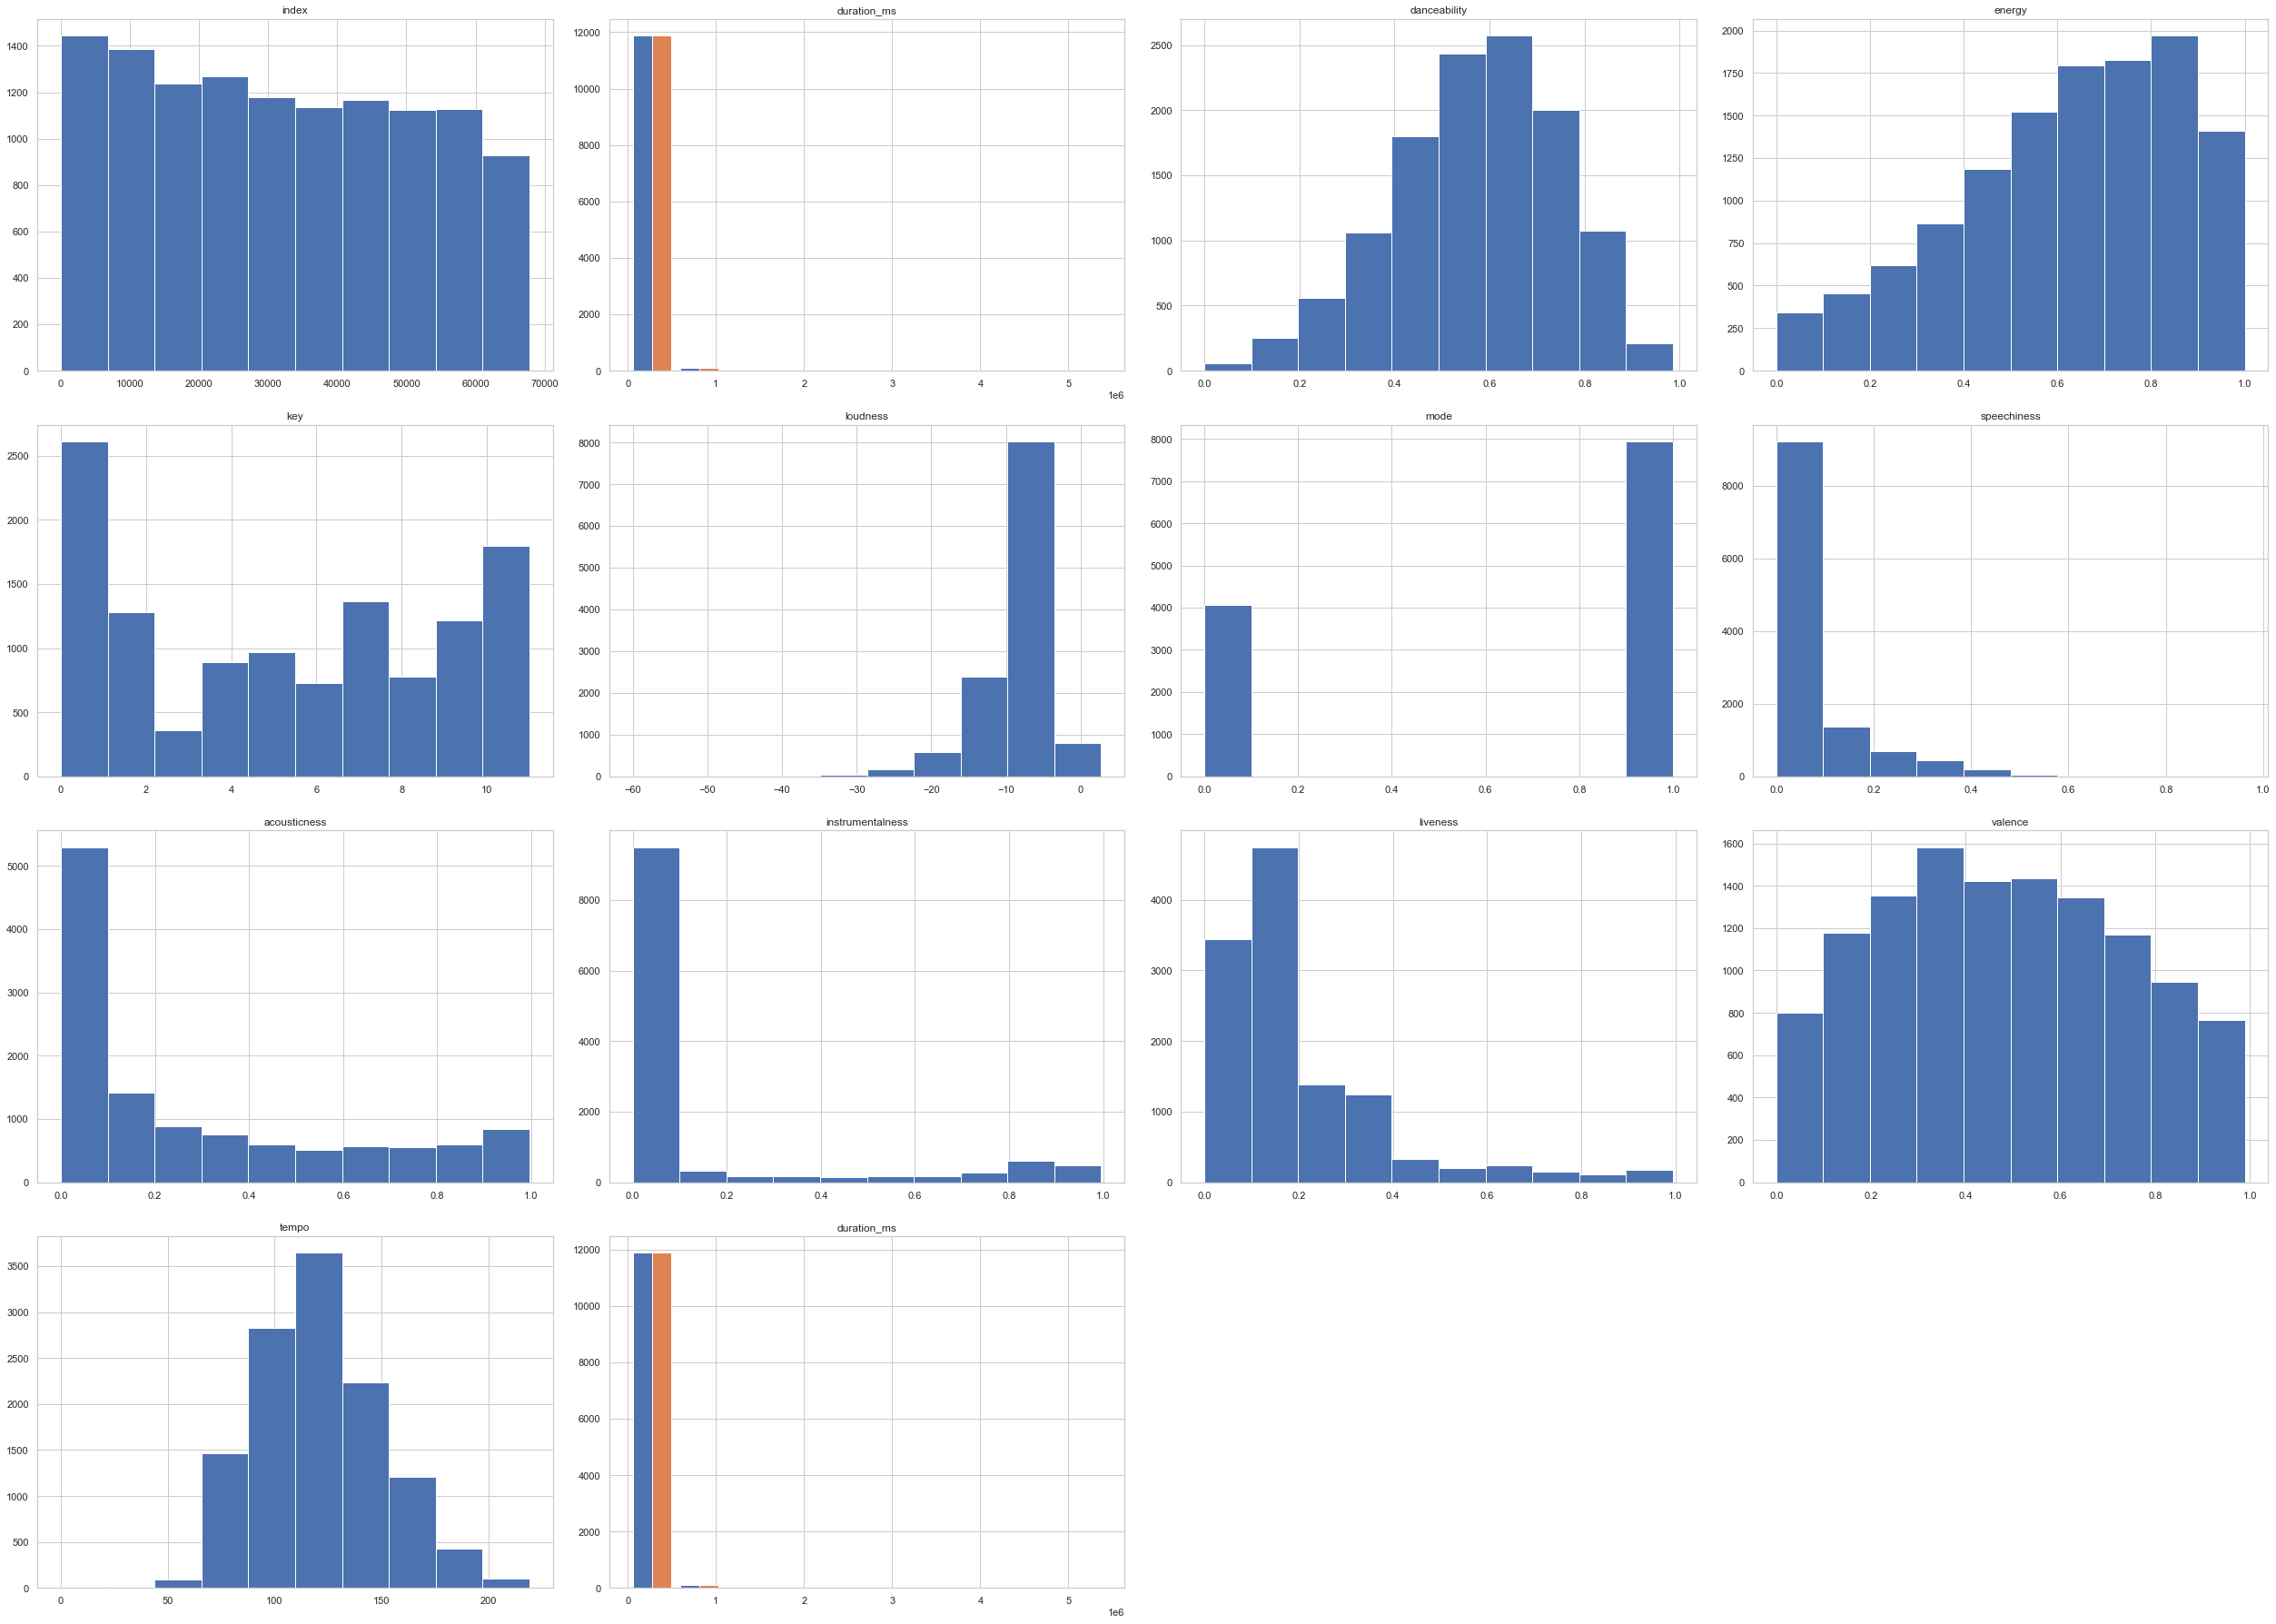

In [239]:
#check for distributions
spotify_df.hist(figsize=(35,25)) 
plt.tight_layout()
plt.show()

In [241]:
spotify_df.isna().sum()

index               0
artist_name         0
track_uri           0
artist_uri          0
track_name          0
album_uri           0
duration_ms         0
album_name          0
playlist            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
type                0
id                  0
uri                 0
track_href          0
analysis_url        0
duration_ms         0
dtype: int64

In [ ]:
features = ['mode','duration_ms','instrumentalness','acousticness','danceability','energy','liveness','loudness','speechiness', 'tempo','valence']

def combine_all_features(row):
    return str(row['mode']) +" "+ str(row['duration_ms']) +" "+ str(row['instrumentalness']) +" "+ str(row['acousticness']) +" "+ str(row['danceability'])+" "+ str(row["energy"])+" "+str(row["liveness"])+" "+str(row["loudness"])+" "+str(row["speechiness"])+" "+str(row["tempo"])+" "+str(row["valence"])

df['combined_features'] = df.apply(combine_all_features,axis=1)


cv = CountVectorizer()
count_matrix = cv.fit_transform(df['combined_features'])
cosine_sim = cosine_similarity(count_matrix)


def fetch_artist_from_index(index):
    return df[df.index == index]["artists"].values[0]

def fetch_index_from_artist(artists):
    return df[df.artists == artists]["index"].values[0]

user_choice_for_singer = "Justin Timberlake"
artist_index = fetch_index_from_artist(user_choice_for_singer)

similar_artists =  list(enumerate(cosine_sim[artist_index]))

sim_artist_sort = sorted(similar_artists,key=lambda x:x[1],reverse=True)[1:]

i=0
print("Top 10 similar artists/singers to "+ user_choice_for_singer +" are:\n")
for element in sim_artist_sort:
    print(i+1,'->',fetch_artist_from_index(element[0]))
    i=i+1
    if i>=10:
        break

In [235]:
def baseline(tracks, spotify_df, n_pred):
    '''
    Input:
    1. tracks = Takes a list of track titles as input (strings)
    2. df = Dataframe containing all track info
    Output:
    recs = Recommends 10 track uri based on info of that string (List of strings)
    '''
    recs = []
    for t in tracks:
        danceability = spotify_df[spotify_df['track_name'] == t]['danceability']
        spotify_df['rec_df_dance'] = np.abs(spotify_df['danceability'] - danceability.values[0])
        one_recs = list(spotify_df.sort_values(by=['rec_df_dance'])['track_name'][1:].values)
        recs = [track for track in one_recs if track not in tracks][0:n_pred]
    preds = Counter(recs).most_common(n_pred)
    pred_titles = [p[0] for p in preds]
    return pred_titles

In [202]:
#drop unecessary columns
to_drop = ['time_signature','Playlist_pos']
spotify_df.drop(to_drop, inplace=True, axis=1)

In [ ]:
train_scaled_cos_matrix.shape

In [206]:
#have to scale data to make it comparable
feature_cols=['acousticness', 'danceability', 'duration_ms', 'energy',
              'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
              'speechiness', 'tempo', 'valence',]

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
normspotify_df =scaler.fit_transform(spotify_df[feature_cols])

print(normspotify_df[:2])

[[5.02008032e-02 9.15821501e-01 2.87505614e-02 2.82032298e-02
  6.12000000e-01 1.23493976e-04 6.36363636e-01 7.39698492e-02
  8.32114113e-01 1.00000000e+00 3.31600832e-01 4.56061870e-01
  6.79474216e-01]
 [7.14859438e-01 7.17038540e-01 2.66178595e-02 2.61452998e-02
  8.35000000e-01 0.00000000e+00 5.45454545e-01 3.92964824e-01
  7.87186230e-01 0.00000000e+00 4.53222453e-02 5.64772888e-01
  9.50455005e-01]]


In [215]:
# Create cosine similarity matrix based on given matrix
indices = pd.Series(spotify_df.index, index=spotify_df['track_name']).drop_duplicates()
cosine = cosine_similarity(normspotify_df)

def generate_recommendation(track_name, model_type=cosine ):
    """
    Purpose: Function for song recommendations 
    Inputs: song title and type of similarity model
    Output: Pandas series of recommended songs
    """
    # Get song indices
    index=indices[track_name]
    # Get list of songs for given songs
    score=list(enumerate(model_type[indices['Parallel Lines']]))
    # Sort the most similar songs
    similarity_score = sorted(score,key = lambda x:x[1],reverse = True)
    # Select the top-50 recommend songs
    similarity_score = similarity_score[1:51]
    top_songs_index = [i[0] for i in similarity_score]
    # Top 50 recommende songs
    top_songs=spotify_df['song_title'].iloc[top_songs_index]
    return top_songs

In [216]:
print("Recommended Songs:")
print(generate_recommendation('Parallel Lines',cosine).values)

Recommended Songs:


KeyError: 'Parallel Lines'

In [218]:
# Take 1 % data as sample  
spotify_df_sample = spotify_df.sample(frac=.40, random_state=1) 

# Shape of the sample data
spotify_df_sample.shape

(4800, 26)

In [245]:
# Create Item-user matrix using pivot_table()
spotify_pivot = spotify_df_sample.pivot_table(index='id', columns='artist_name', values='energy').fillna(0)

# Show top-5 records
spotify_pivot.head()

artist_name,$uicideBoy$,*NSYNC,1000volts,11/5,21 Savage,24K,24hrs,25 hours,2Cellos,2NE1,2Pac,3030,311,3OH!3,4Him,5 Reasons,5 Seconds of Summer,50 Cent,6LACK,6ix,A Boogie Wit da Hoodie,A Day To Remember,A Perfect Circle,A R I Z O N A,A Silent Film,A Touch Of Class,A Tribe Called Quest,A$AP Ferg,A$AP Mob,A&G,A-Mei Chang,A.C. Newman,A.R. Rahman,ABSRDST,AC/DC,AJJ,ALO,ASTR,Aaron Copland,Aaron Foret,Aaron Lee Tasjan,Aaron Neville,Aaron Watson,Aaron Y Su Grupo Ilusion,Abie Rotenberg,Abner Jay,Above & Beyond,Above Envy,Abstract,Acaboy's,...,Zaz,Zedd,Zeds Dead,Zee Avi,Zero 7,Ziggy Marley,Zion,Zion & Lennox,Zion I,Zion.T,Zodiac Death Valley,Zoey Dollaz,Zomboy,Zoé,Zubeen Garg,Zuna,Zuse,alt-J,blackbear,blink-182,dandelion hands,deadmau5,dné,eMorphiX Guided Meditation,eevee,f(x),filous,fun.,ghost and tape,iMAGiN8,kp,luxury elite,maudlin of the Well,mewithoutYou,moe.,ronsocold,shiro-P,solo andata,t.A.T.u.,tiasu,tobyMac,xKore,Ásgeir,Ñejo,Óscar Medina,Полина Гагарина,חמי רודנר,卓文萱,成龍,炎亞綸
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
003U4oQXv82GYo1tNquN2F,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00BPafOXD4Pz6Zk7Wklm1Q,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00XT6cE0w2zVkcWmsz7Vh6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00iCPbyEv5KLLwbjJNYXqW,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00kIWJu9IHiQ6i0qJAU0Z9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [246]:
# Import NearestNeighbors
from sklearn.neighbors import NearestNeighbors

# Build NearestNeighbors Object
model_nn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=7, n_jobs=-1)

# Fit the NearestNeighbor
model_nn.fit(spotify_pivot)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=7)

In [248]:
# Get top 10 nearest neighbors 
indices=model_nn.kneighbors(spotify_pivot.loc[['00XT6cE0w2zVkcWmsz7Vh6']], 50, return_distance=False)

# Print the recommended books
print("Recommended Songs:")
print("==================")
for index, value in enumerate(spotify_pivot.index[indices][0]):
    print((index+1),". ",value)

Recommended Songs:
1 .  00XT6cE0w2zVkcWmsz7Vh6
2 .  57p8CBvPOxrvyCbn6ttl5r
3 .  58eKLwmiYrJAqNlv96pwlP
4 .  58TSnL4BqEh8na5mXzPdjX
5 .  58MthbQQ8mcREzfrfa6may
6 .  58MeE6yNEuYFiUouXLvvCQ
7 .  589CLHMsRVR66WU0xrMUj8
8 .  588YI1Nkw5SzS5L7Z4C1bW
9 .  586Wzvkx6tneBmkZFYwFJe
10 .  583InhqAFS5kMg3FNOBQI6
11 .  57wYyAwumNXyh6LudPrDZI
12 .  57wHkkF1QLxQRMhcC3yELI
13 .  5B9Ib3GFEJauhpdIo0jwFJ
14 .  57eAVzbqBxDAbu0OytWueo
15 .  551Om5f5UoL9qz8I8Elux8
16 .  54sdWnKoHjxaYVsdHia9gn
17 .  55PULldftedylAcvuJoEPb
18 .  55MhdrnEnwoWYip8SMMb4n
19 .  55M337gwpQhg9uukxcIj05
20 .  55LhCEkBGFj95SyhuhlSE6
21 .  55EvroOzt6eieudauqAC6s
22 .  55C8Zut2Ug8wPNrU4OJYPd
23 .  55XxeEsRBc9kjRnra8GwAB
24 .  58jBNCq3K6fCfUpUiTG2gK
25 .  58m5GhbvKpt1qDIdH1xflb
26 .  58r4JuwHhXLAkttkaUZfLw
27 .  58ylUARtBlCP1JX8rf7ZYj
28 .  57awyWlR4Itwb2DFIFmd9i
29 .  5B4NZbi9RCIFXe3m1hvPTc
30 .  5AnszA1GMtDt8CFIWMnwyg
31 .  5AeoHJUx0PJXAzN425xryh
32 .  5AWQnmcrXODkY1MrqEOji1
33 .  5AQZS6nBzbJ0qTULHHOLeL
34 .  5AKF0E0w03ejmugJNdGm5p
35 .

<ipython-input-248-3d798cd7ca06>:7: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  for index, value in enumerate(spotify_pivot.index[indices][0]):


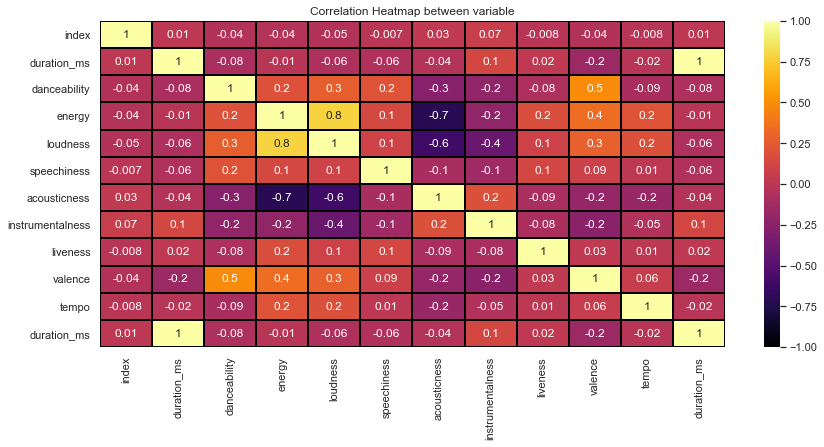

In [250]:
from matplotlib.patches import Rectangle
corr_df=spotify_df.drop(["key","mode"],axis=1).corr(method="pearson")
plt.figure(figsize=(14,6))
heatmap=sns.heatmap(corr_df,annot=True,fmt=".1g",vmin=-1,vmax=1,center=0,cmap='inferno',linewidths=1,linecolor="Black")
heatmap.set_title("Correlation Heatmap between variable")
heatmap.set_xticklabels(heatmap.get_xticklabels(),rotation=90);

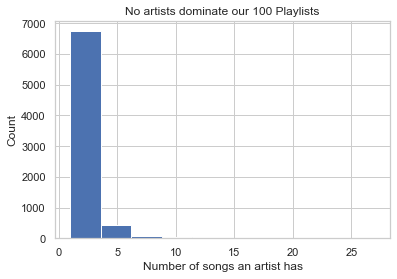

In [197]:
plt.hist(spotify_df['artist_name'].value_counts())
plt.title("No artists dominate our 100 Playlists")
plt.ylabel("Count")
plt.xlabel("Number of songs an artist has")
plt.show()

Text(0.5, 0, 'Total songs across playlists')

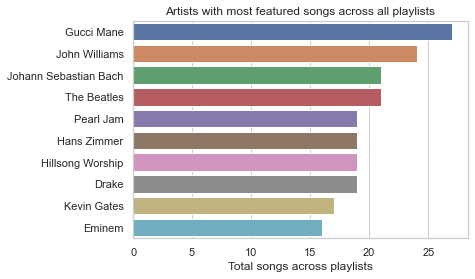

In [188]:
# Checking which artists are featured most across all playlists
values = list(spotify_df['artist_name'].value_counts())
names = spotify_df['artist_name'].value_counts().index.tolist()

ax = sns.barplot(y=names[0:10], x=values[0:10])
ax.set_title('Artists with most featured songs across all playlists')
ax.set_xlabel('Total songs across playlists')

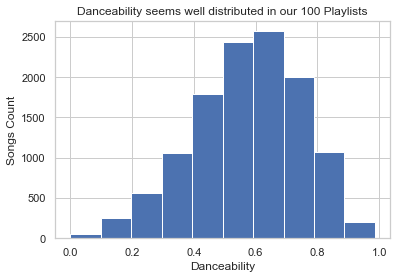

In [189]:
plt.hist(spotify_df['danceability'])
plt.title("Danceability seems well distributed in our 100 Playlists")
plt.ylabel("Songs Count")
plt.xlabel("Danceability")
plt.show()

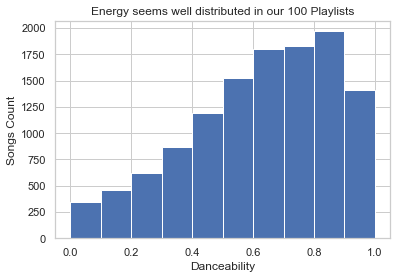

In [252]:
plt.hist(spotify_df['energy'])
plt.title("Energy seems well distributed in our 100 Playlists")
plt.ylabel("Songs Count")
plt.xlabel("Danceability")
plt.show()

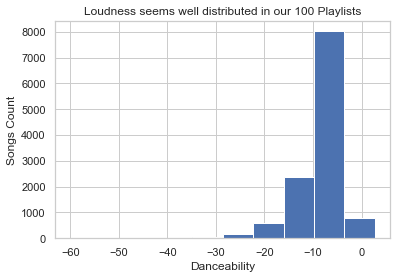

In [253]:
plt.hist(spotify_df['loudness'])
plt.title("Loudness seems well distributed in our 100 Playlists")
plt.ylabel("Songs Count")
plt.xlabel("Danceability")
plt.show()

In [193]:
spotify_df.to_csv('spotifymillionandapi.csv')

# Models

## Cosine Similarity Model

In [289]:
def clean_and_scale(df):
    
    dance_ohe = pd.get_dummies(df['danceability'])
    df = spotify_df.join(dance_ohe)
    df = df.drop(['track_name', 'artist_name', 'danceability', 'playlist'], axis=1).set_index('id')
    
    scaled = MinMaxScaler().fit_transform(df)
    scaled_df = pd.DataFrame(data=scaled, index=df.index)
    
    return scaled_df

In [290]:
scaled_df = clean_and_scale(spotify_df)
scaled_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899,900,901,902,903,904,905,906,907,908,909,910,911
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3OGuiEDR8XXjaWqbOaVqUA,0.204225,0.028751,0.612,0.636364,0.832114,1.0,0.331601,0.050201,0.000123,0.073970,0.679474,0.456062,0.028203,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7GC4k7X9a7NW98p1ODZjZg,0.097812,0.026618,0.835,0.545455,0.787186,0.0,0.045322,0.714859,0.000000,0.392965,0.950455,0.564773,0.026145,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1FYJSBSShfORqU2yUFQGXS,0.334238,0.090690,0.821,0.818182,0.763535,0.0,0.193347,0.960843,0.923695,0.100302,0.331648,0.501402,0.090177,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0LSegQAZFXyKV5EWCBK1He,0.445946,0.042100,0.446,0.000000,0.808176,1.0,0.031913,0.085040,0.000000,0.189950,0.626896,0.414771,0.041560,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5VUZ3kwdQHr9rMVkJot15R,0.317924,0.050994,0.279,0.000000,0.730656,1.0,0.035031,0.547189,0.003133,0.282412,0.619818,0.630036,0.050459,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5IN7CHKxzc2FoSFDx1JqS0,0.880917,0.114309,0.122,0.090909,0.665439,1.0,0.156965,0.025703,0.000094,0.090553,0.285137,0.556542,0.113810,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0IavpjES4TgnNw2RPYDDey,0.042748,0.040010,0.764,0.090909,0.876436,1.0,0.140333,0.104418,0.000035,0.328643,0.257836,0.419518,0.039469,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [291]:
cosine = cosine_similarity(scaled_df)
cos_df = pd.DataFrame(data=cosine, index=model_df.index)
cos_df

NameError: name 'model_df' is not defined

In [288]:
spotify_df

,index,artist_name,track_name,duration_ms,playlist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,duration_ms
0,13845,Mariahlynn,Once Upon a Time,156000,On the Run,0.903,0.612,7,-7.789,1,0.3190,0.0500,0.000123,0.0736,0.672,100.013,3OGuiEDR8XXjaWqbOaVqUA,156000
1,6631,Neil Sedaka,Next Door To An Angel,144428,Oldies,0.707,0.835,6,-10.608,0,0.0436,0.7120,0.000000,0.3910,0.940,123.853,7GC4k7X9a7NW98p1ODZjZg,144840
2,22659,Forest Swords,"Friend, You Will Never Learn",492080,December,0.354,0.821,9,-12.092,0,0.1860,0.9570,0.920000,0.0998,0.328,109.956,1FYJSBSShfORqU2yUFQGXS,492080
3,30232,Boyce Avenue,Jumper,228434,Acoustic,0.716,0.446,0,-9.291,1,0.0307,0.0847,0.000000,0.1890,0.620,90.958,0LSegQAZFXyKV5EWCBK1He,228435
4,21553,Genoa Keawe,Alika,276693,Hawaiian,0.422,0.279,0,-14.155,1,0.0337,0.5450,0.003120,0.2810,0.613,138.165,5VUZ3kwdQHr9rMVkJot15R,276693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,59720,St Germain,Sentimental Mood,620240,Chill out,0.787,0.122,1,-18.247,1,0.1510,0.0256,0.000093,0.0901,0.282,122.048,5IN7CHKxzc2FoSFDx1JqS0,620240
11996,2898,Omar LinX,Can't Forget,217093,Rap,0.709,0.764,1,-5.008,1,0.1350,0.1040,0.000035,0.3270,0.255,91.999,0IavpjES4TgnNw2RPYDDey,217093
11997,2505,Henry Gross,Shannon,253200,Movie Songs,0.431,0.293,5,-11.635,1,0.1700,0.7590,0.000002,0.1240,0.678,176.647,4xlz9mvlXko4Ccnb4gLjWJ,253200
11998,31295,Dennis Sheperd,Fallen Angel - Dennis Sheperd Radio Edit,214545,A playlist.,0.509,0.910,5,-7.841,0,0.0418,0.0119,0.017000,0.2620,0.333,131.973,6VbCaW5zcl9Ir5UxewNtw6,214545
